## 0.Vancomycin AUC Prediction Model Development and Validation


##### *Overview: This notebook develops a machine-learning model to predict vancomycin AUC overexposure in hospitalized patients.*

<small><i>
* **#1 Binary classification:** target = AUC > 600 mg·h/L (high-risk vs low-risk).
* **#2 Preprocessing:** consistent column cleaning; no SMOTE; class imbalance handled via `class_weight/scale_pos_weight`; automatic scaler for linear/SVM models only.
* **#3 Models (9 total):** Logistic Regression (**L1, L2, ElasticNet, None**), **SVM (RBF)**, **Random Forest**, **Gradient Boosting**, **XGBoost**, **CatBoost**, plus **Soft-Voting Ensemble** (LightGBM excluded).
* **#4 Tuning metric:** PR-AUC (`average_precision`) with 5-fold **Stratified CV (shuffle=False)** on the training set.
* **#5 Thresholding (train-CV only):** compute **F1-max** and **Youden (J=TPR−FPR)** per fold; fix the **median** threshold; apply unchanged to validation and external sets (no on-the-fly tuning).
* **#6 Primary analysis:** **Logistic Regression (ElasticNet) @ Youden(CV)** is the prespecified main model/operating point.
* **#7 Internal validation:** time-based 80:20 hold-out with full operating metrics and confusion matrices.
* **#8 PrecisePK comparison:** head-to-head against the commercial tool on the same validation segment.
* **#9 External validation:** independent cohort evaluated with the exact training feature contract and the CV-fixed thresholds.
* **#10 Explainability:** SHAP (LinearExplainer) for the primary model; export top features and publication-quality plots/tables.
</i></small>


## 1. Environment Setup and Dependencies

In [1]:
# ==========================================
# Install (Colab)
# ==========================================
# Only what's needed beyond stock Colab
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.9 MB/s eta 0:00:00


In [2]:
# ==========================================
# Core imports & global settings
# ==========================================
import os
import random
import warnings
from collections import OrderedDict

import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# IO / utils
from PIL import Image
from google.colab import files
import joblib
import shap

# Jupyter display
from IPython.display import display

# Reproducibility & display defaults
np.random.seed(42)
random.seed(42)
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# ==========================================
# Modeling toolkit (scikit-learn + boosters)
# ==========================================
from scipy import sparse
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    roc_curve,
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


 ## 2. Data Loading and Initial Exploration

In [3]:
uploaded = files.upload()
for filename in uploaded.keys():
    df_full = pd.read_excel(filename)
    print(f"Full dataset loaded: {filename}")

Saving Vancomycin_auc_prediction_training.xlsx to Vancomycin_auc_prediction_training.xlsx
Full dataset loaded: Vancomycin_auc_prediction_training.xlsx


In [4]:
print(f"Dataset loaded: {filename} | shape={df_full.shape}")
df_full.info()
print("\nMissing values:\n", df_full.isna().sum())
df_full.head()

Dataset loaded: Vancomycin_auc_prediction_training.xlsx | shape=(553, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Male                    553 non-null    int64  
 1   Initial VCM_daily_dose  553 non-null    int64  
 2   AUC                     553 non-null    float64
 3   Scr                     553 non-null    float64
 4   Cockcroft-Gault CrCl    553 non-null    float64
 5   MDRD                    553 non-null    float64
 6   Age                     553 non-null    int64  
 7   BW                      553 non-null    float64
 8   Height                  553 non-null    float64
 9   BMI                     553 non-null    float64
 10  NSAIDs                  553 non-null    int64  
 11  Vasopressors            553 non-null    int64  
 12  FLC                     553 non-null    int64  
 13  FQ                   

,Male,Initial VCM_daily_dose,AUC,Scr,Cockcroft-Gault CrCl,MDRD,Age,BW,Height,BMI,NSAIDs,Vasopressors,FLC,FQ,LAB,AG,TZP,ARB,ACEi,Furosemide,Diuretics,ICU,WBC,RBC,Hb,PLT,CRP,BUN,Albumin,TP,UA
0,0,2000,509.0,0.61,69.439891,96.686509,71,52.0,150.0,23.111111,0,0,0,0,0,0,0,0,0,0,0,0,5.5,3.46,11.7,167,3.62,11.0,3.7,6.2,2.1
1,1,2400,515.0,0.86,61.046512,86.232151,77,60.0,160.0,23.437500,1,0,0,0,0,0,0,0,0,0,0,0,3.9,3.49,9.5,159,89.05,12.0,3.4,6.5,3.3
2,1,1500,472.0,0.60,71.759259,130.303566,78,50.0,151.0,21.928863,0,0,0,0,0,0,0,0,0,0,0,0,9.4,3.84,11.0,255,8.00,14.0,3.3,7.8,4.4
3,1,1600,456.0,1.27,56.496063,58.246881,58,63.0,168.0,22.321429,0,0,0,0,0,0,0,0,0,0,0,0,7.3,3.75,11.1,223,24.45,16.9,4.2,6.7,5.0
4,1,1800,411.0,0.81,66.872428,92.898543,75,60.0,168.0,21.258503,1,0,0,0,0,0,0,0,0,0,0,0,0.4,2.89,9.2,65,91.59,12.8,2.8,5.4,4.4


Shape: (553, 32)
               AUC
count   553.000000
mean    472.734250
std     171.446857
min     111.000000
25%     360.000000
50%     445.000000
75%     549.000000
max    1564.000000

Class balance (AUC>600):
AUC_over600
≤600    458
>600     95
Name: count, dtype: int64


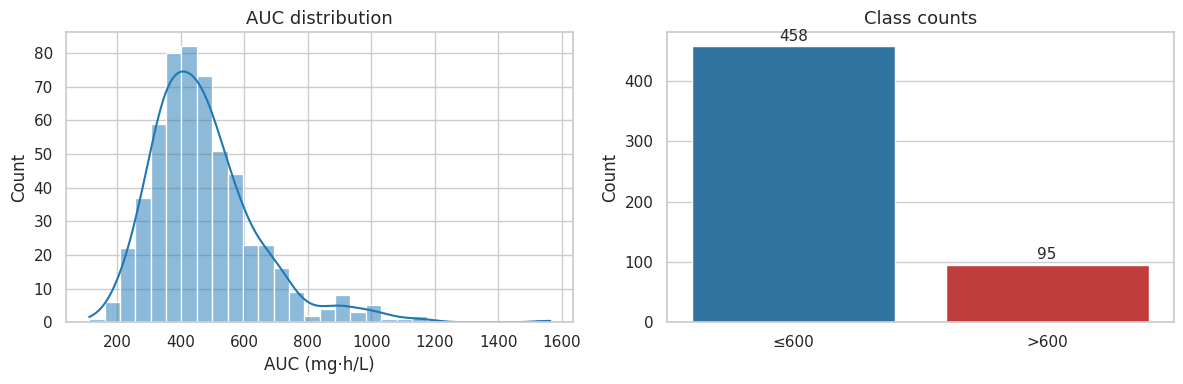

In [5]:
# --- Setup & target

df = df_full.copy()
df["AUC_over600"] = (df["AUC"] > 600).astype(int)

print("Shape:", df.shape)
print(df[["AUC"]].describe())
print("\nClass balance (AUC>600):")
print(df["AUC_over600"].value_counts().rename({0: "≤600", 1: ">600"}))

assert df.isna().sum().sum() == 0, "Missing values found."
assert df.duplicated().sum() == 0, "Duplicate rows found."

# --- Pretty plots: ONE figure with two panels
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# AUC histogram + KDE
sns.histplot(data=df, x="AUC", bins=30, kde=True, color="#1f77b4", ax=axes[0])
axes[0].set_title("AUC distribution", fontsize=13)
axes[0].set_xlabel("AUC (mg·h/L)")
axes[0].set_ylabel("Count")

# Class counts (≤600 vs >600)
class_counts = df["AUC_over600"].value_counts().sort_index()
sns.barplot(x=["≤600", ">600"], y=class_counts.values,
            palette=["#1f77b4", "#d62728"], ax=axes[1])
for i, v in enumerate(class_counts.values):
    axes[1].text(i, v + max(class_counts)*0.02, str(v), ha="center", fontsize=11)
axes[1].set_title("Class counts", fontsize=13)
axes[1].set_ylabel("Count")
axes[1].set_xlabel("")

plt.tight_layout()
plt.show()


In [6]:
fig.savefig("auc_distribution.png", dpi=300, bbox_inches="tight")
files.download("auc_distribution.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# 1) Column sanitize (global) + mapping
orig_cols = df.columns
sanitized = (
    df.columns.str.strip()                      # trim spaces
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[-/]", "_", regex=True)
              .str.replace(r"[^0-9A-Za-z_]", "", regex=True)
)
rename_map = dict(zip(orig_cols, sanitized))
df = df.rename(columns=rename_map)

# 2) Binary columns → numeric 0/1 + validation
binary_cols = ['Male','NSAIDs','Vasopressors','FLC','FQ','LAB','AG','TZP',
               'ARB','ACEi','Furosemide','Diuretics','ICU']
for c in binary_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
        bad = set(df[c].unique()) - {0, 1}
        if bad:
            print(f"Warning: {c} has non-binary values: {sorted(bad)}")

# 3) Feature matrix (numeric) + presence check
feature_cols_clean = ['Male','Initial_VCM_daily_dose','Scr','Cockcroft_Gault_CrCl','MDRD',
                      'Age','BW','Height','BMI','NSAIDs','Vasopressors','FLC','FQ','LAB','AG',
                      'TZP','ARB','ACEi','Furosemide','Diuretics','ICU','WBC','RBC','Hb','PLT',
                      'CRP','BUN','Albumin','TP','UA']

missing = [c for c in feature_cols_clean if c not in df.columns]
if missing:
    print(f"Warning: missing expected columns: {missing}")
    feature_cols_clean = [c for c in feature_cols_clean if c in df.columns]

X = df[feature_cols_clean].apply(pd.to_numeric, errors="coerce")
y_cls = pd.to_numeric(df['AUC_over600'], errors="coerce").astype(int)
y_reg = pd.to_numeric(df['AUC'], errors="coerce")

print("X shape:", X.shape, "| y_cls positive rate:", round(y_cls.mean(), 4))
print("Columns (sanitized):", list(X.columns))


X shape: (553, 30) | y_cls positive rate: 0.1718
Columns (sanitized): ['Male', 'Initial_VCM_daily_dose', 'Scr', 'Cockcroft_Gault_CrCl', 'MDRD', 'Age', 'BW', 'Height', 'BMI', 'NSAIDs', 'Vasopressors', 'FLC', 'FQ', 'LAB', 'AG', 'TZP', 'ARB', 'ACEi', 'Furosemide', 'Diuretics', 'ICU', 'WBC', 'RBC', 'Hb', 'PLT', 'CRP', 'BUN', 'Albumin', 'TP', 'UA']


## 3. Data preparation


In [8]:
# ==========================================
# Time-based split (80:20)
# ==========================================

def time_based_split(X: pd.DataFrame, y: pd.Series, ratio: float = 0.80):
    """
    Time-ordered split: first 'ratio' portion for train, last portion for validation.
    Assumes current row order reflects chronological order (earliest → latest).
    """
    n = len(X)
    split_idx = int(n * ratio)
    X_tr, X_va = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
    y_tr, y_va = y.iloc[:split_idx].copy(), y.iloc[split_idx:].copy()
    return X_tr, X_va, y_tr, y_va

def describe_split(y_tr: pd.Series, y_va: pd.Series, label_pos: int = 1):
    """Print dataset sizes and class balance for train/validation sets."""
    pos_tr = int((y_tr == label_pos).sum()); neg_tr = len(y_tr) - pos_tr
    pos_va = int((y_va == label_pos).sum()); neg_va = len(y_va) - pos_va
    print(f"Train size: {len(y_tr)} "
          f"(pos={pos_tr}, neg={neg_tr}, pos%={pos_tr/len(y_tr):.4f})")
    print(f"Valid size: {len(y_va)} "
          f"(pos={pos_va}, neg={neg_va}, pos%={pos_va/len(y_va):.4f})")

# --- Apply 80:20 time-based split --------------------------------------------
X_train, X_val, y_train, y_val = time_based_split(X, y_cls, ratio=0.80)

print("[Final] Time-based split 80:20")
describe_split(y_train, y_val)


[Final] Time-based split 80:20
Train size: 442 (pos=77, neg=365, pos%=0.1742)
Valid size: 111 (pos=18, neg=93, pos%=0.1622)


## 4. Model development


In [9]:
# ===============================================================
# CV-based thresholding WITHOUT sensitivity constraint
# - Hyperparameter tuning: PR-AUC (average_precision)
# - Threshold selection on TRAIN-CV: F1-max, Youden (J = TPR - FPR)
# - Evaluation: apply the CV-fixed thresholds to validation (and external if provided)
# ===============================================================

# -----------------------------
# Settings / guards
# -----------------------------

RANDOM_STATE = 42
SCORING = "average_precision"   # tuning metric

for var in ["X_train", "X_val", "y_train", "y_val"]:
    if var not in globals():
        raise NameError(f"{var} is not defined. Run your 80:20 split cell first.")

# class imbalance helpers (for tree/boosting & catboost)
n_pos = int((y_train == 1).sum()); n_neg = int((y_train == 0).sum())
scale_pos_weight = (n_neg / n_pos) if n_pos > 0 else 1.0
catboost_class_weights = [1.0, scale_pos_weight]
print(f"[Info] Train pos={n_pos}, neg={n_neg}, pos%={n_pos/len(y_train):.4f}")
print(f"[Info] XGB scale_pos_weight={scale_pos_weight:.3f} | CatBoost class_weights={catboost_class_weights}")

# auto scaler: sparse -> with_mean=False, dense -> default
IS_SPARSE = sparse.issparse(X_train)
SCALER_FOR_PIPE = StandardScaler(with_mean=not IS_SPARSE)

# -----------------------------
# Helpers
# -----------------------------
def pick_threshold_f1max(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
    idx = int(np.argmax(f1))  # index in PR points (len = len(thr)+1)
    if len(thr) == 0:
        return 0.5  # degenerate
    if idx == 0:
        return float(thr[0])  # first point has no thr; use the first boundary
    return float(thr[idx-1])

def pick_threshold_youden(y_true, proba):
    fpr, tpr, thr = roc_curve(y_true, proba)
    j = tpr - fpr
    best = int(np.argmax(j))
    # roc_curve는 각 점에 대응하는 thr가 있음
    return float(thr[best])

def eval_fixed_threshold(estimator, X, y, thr):
    proba = estimator.predict_proba(X)[:, 1]
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    return {
        "PR-AUC": average_precision_score(y, proba),
        "ROC-AUC": roc_auc_score(y, proba),
        "F1": f1_score(y, pred, zero_division=0),
        "Sensitivity": recall_score(y, pred, zero_division=0),
        "Specificity": tn/(tn+fp) if (tn+fp) else 0.0,
        "PPV": precision_score(y, pred, zero_division=0),
        "NPV": tn/(tn+fn) if (tn+fn) else 0.0,
        "Accuracy": accuracy_score(y, pred),
        "TP": int(tp), "FN": int(fn), "FP": int(fp), "TN": int(tn),
        "Threshold": float(thr)
    }

def cv_pick_threshold(estimator, X_tr, y_tr, cv, method="f1max"):
    thrs = []
    for tr_idx, va_idx in cv.split(X_tr, y_tr):
        X_tr_i, X_va_i = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
        y_tr_i, y_va_i = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]
        est = clone(estimator)
        est.fit(X_tr_i, y_tr_i)
        if not hasattr(est, "predict_proba"):
            raise AttributeError("Estimator needs predict_proba (e.g., SVC(probability=True)).")
        proba = est.predict_proba(X_va_i)[:, 1]
        if method == "f1max":
            thr_i = pick_threshold_f1max(y_va_i, proba)
        elif method == "youden":
            thr_i = pick_threshold_youden(y_va_i, proba)
        else:
            raise ValueError("method must be one of {'f1max','youden'}")
        thrs.append(thr_i)
    thr_fixed = float(np.median(thrs)) if len(thrs) else 0.5
    return thr_fixed, thrs

# -----------------------------
# CV definition (review-safe)
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=False)

# -----------------------------
# Define models + grids (no SMOTE)
# -----------------------------
pipe_lr_none = Pipeline([
    ("scaler", SCALER_FOR_PIPE),
    ("clf", LogisticRegression(
        penalty=None, solver="saga", max_iter=5000,
        class_weight="balanced", random_state=RANDOM_STATE
    ))
]); grid_lr_none = {}

pipe_lr_l2 = Pipeline([
    ("scaler", SCALER_FOR_PIPE),
    ("clf", LogisticRegression(
        penalty="l2", solver="saga", max_iter=5000,
        class_weight="balanced", random_state=RANDOM_STATE
    ))
]); grid_lr_l2 = {"clf__C": [0.05, 0.1, 0.3, 1.0, 3.0]}

pipe_lr_l1 = Pipeline([
    ("scaler", SCALER_FOR_PIPE),
    ("clf", LogisticRegression(
        penalty="l1", solver="saga", max_iter=5000,
        class_weight="balanced", random_state=RANDOM_STATE
    ))
]); grid_lr_l1 = {"clf__C": [0.05, 0.1, 0.3, 1.0, 3.0]}

pipe_lr_en = Pipeline([
    ("scaler", SCALER_FOR_PIPE),
    ("clf", LogisticRegression(
        penalty="elasticnet", solver="saga", max_iter=5000,
        class_weight="balanced", random_state=RANDOM_STATE
    ))
]); grid_lr_en = {
    "clf__C": [0.05, 0.1, 0.3, 1.0, 3.0],
    "clf__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

pipe_svm = Pipeline([
    ("scaler", SCALER_FOR_PIPE),
    ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE))
]); grid_svm = {
    "clf__C": [0.5, 1.0, 3.0, 10.0],
    "clf__gamma": ["scale", 0.1, 0.01],
    "clf__kernel": ["rbf"]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1)
grid_rf = {"n_estimators": [200, 500], "max_depth": [None, 5, 10], "min_samples_leaf": [1, 3, 5]}

gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
grid_gb = {"n_estimators": [200, 500], "learning_rate": [0.03, 0.1], "max_depth": [2, 3]}

xgb = XGBClassifier(
    eval_metric="logloss", use_label_encoder=False, tree_method="hist",
    random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
)
grid_xgb = {"max_depth": [2, 3, 4], "learning_rate": [0.03, 0.1], "n_estimators": [300, 600],
            "subsample": [0.8, 1.0], "colsample_bytree": [0.8, 1.0]}

cb = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE, class_weights=catboost_class_weights)
grid_cb = {"depth": [4, 6], "learning_rate": [0.03, 0.1],
           "l2_leaf_reg": [1, 3, 5], "iterations": [400, 800]}

models_grids = OrderedDict([
    ("LR-none", (pipe_lr_none, grid_lr_none)),
    ("LR-L2", (pipe_lr_l2, grid_lr_l2)),
    ("LR-L1", (pipe_lr_l1, grid_lr_l1)),
    ("LR-ElasticNet", (pipe_lr_en, grid_lr_en)),
    ("SVM-RBF", (pipe_svm, grid_svm)),
    ("RandomForest", (rf, grid_rf)),
    ("GradientBoost", (gb, grid_gb)),
    ("XGBoost", (xgb, grid_xgb)),
    ("CatBoost", (cb, grid_cb)),
])

# -----------------------------
# Inner-CV tuning (training only)
# -----------------------------
best_models, cv_rows = OrderedDict(), []
for name, (estimator, grid) in models_grids.items():
    gs = GridSearchCV(estimator=estimator, param_grid=grid, scoring=SCORING,
                      cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    cv_rows.append({"Model": name, "BestParams": gs.best_params_, "CV(PR-AUC)": round(gs.best_score_, 4)})
    print(f"[{name}] best params: {gs.best_params_} | CV PR-AUC: {gs.best_score_:.4f}")

cv_table = pd.DataFrame(cv_rows).sort_values("CV(PR-AUC)", ascending=False).reset_index(drop=True)
print("\n=== Inner-CV summary (training only) ===")
display(cv_table)

# -----------------------------
# Thresholds from TRAIN-CV: F1-max & Youden
# -----------------------------
thr_tables = []
fixed_thr_by_method = {"f1max": {}, "youden": {}}

for name, est in best_models.items():
    # F1-max
    thr_f1, f1_list = cv_pick_threshold(est, X_train, y_train, cv=cv, method="f1max")
    fixed_thr_by_method["f1max"][name] = thr_f1
    # Youden
    thr_y, y_list = cv_pick_threshold(est, X_train, y_train, cv=cv, method="youden")
    fixed_thr_by_method["youden"][name] = thr_y

    thr_tables.append({
        "Model": name,
        "FixedThreshold(F1-max,CV-median)": thr_f1,
        "FixedThreshold(Youden,CV-median)": thr_y
    })

thr_table = pd.DataFrame(thr_tables).sort_values("Model").reset_index(drop=True)
print("\n=== Fixed thresholds from TRAIN-CV (F1-max & Youden) ===")
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(thr_table)

# -----------------------------
# Validation eval with CV-fixed thresholds
# -----------------------------
val_rows = []
for name, model in best_models.items():
    # Fixed 0.5 baseline
    val_rows.append({"Model": name, "Method": "Fixed(0.5)", **eval_fixed_threshold(model, X_val, y_val, 0.5)})
    # F1-max (from TRAIN-CV)
    thr_f1 = fixed_thr_by_method["f1max"][name]
    val_rows.append({"Model": name, "Method": "F1-max(CV)", **eval_fixed_threshold(model, X_val, y_val, thr_f1)})
    # Youden (from TRAIN-CV)
    thr_y = fixed_thr_by_method["youden"][name]
    val_rows.append({"Model": name, "Method": "Youden(CV)", **eval_fixed_threshold(model, X_val, y_val, thr_y)})

valid_table = pd.DataFrame(val_rows).sort_values(["Method","PR-AUC","F1"], ascending=[True, False, False]).reset_index(drop=True)
print("\n=== Validation with CV-fixed thresholds (no on-the-fly tuning) ===")
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(valid_table)

# -----------------------------
# Soft voting ensemble (optional) — same CV-thresholding
# -----------------------------
ensemble_keys = [k for k in ["LR-L1","LR-L2","SVM-RBF","RandomForest","XGBoost","CatBoost"] if k in best_models]
if ensemble_keys:
    estimators = [(k, best_models[k]) for k in ensemble_keys]
    ens = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)

    # thresholds from TRAIN-CV
    thr_ens_f1, _ = cv_pick_threshold(ens, X_train, y_train, cv=cv, method="f1max")
    thr_ens_y, _  = cv_pick_threshold(ens, X_train, y_train, cv=cv, method="youden")

    ens.fit(X_train, y_train)
    ens_val_f05 = {"Model": f"Ensemble({'+'.join(ensemble_keys)})", "Method": "Fixed(0.5)", **eval_fixed_threshold(ens, X_val, y_val, 0.5)}
    ens_val_f1  = {"Model": f"Ensemble({'+'.join(ensemble_keys)})", "Method": "F1-max(CV)", **eval_fixed_threshold(ens, X_val, y_val, thr_ens_f1)}
    ens_val_y   = {"Model": f"Ensemble({'+'.join(ensemble_keys)})", "Method": "Youden(CV)", **eval_fixed_threshold(ens, X_val, y_val, thr_ens_y)}
    print("\n=== Soft Voting Ensemble (validation, CV-fixed thresholds) ===")
    display(pd.DataFrame([ens_val_f05, ens_val_f1, ens_val_y]))

    if "X_ext" in globals() and "y_ext" in globals():
        ens_ext_f05 = {"Model": f"Ensemble({'+'.join(ensemble_keys)})", "Method": "Fixed(0.5)", **eval_fixed_threshold(ens, X_ext, y_ext, 0.5)}
        ens_ext_f1  = {"Model": f"Ensemble({'+'.join(ensemble_keys)})", "Method": "F1-max(CV)", **eval_fixed_threshold(ens, X_ext, y_ext, thr_ens_f1)}
        ens_ext_y   = {"Model": f"Ensemble({'+'.join(ensemble_keys)})", "Method": "Youden(CV)", **eval_fixed_threshold(ens, X_ext, y_ext, thr_ens_y)}
        print("\n=== Soft Voting Ensemble (external, CV-fixed thresholds) ===")
        display(pd.DataFrame([ens_ext_f05, ens_ext_f1, ens_ext_y]))
else:
    print("\n[Info] Ensemble skipped (no eligible base models).")


[Info] Train pos=77, neg=365, pos%=0.1742
[Info] XGB scale_pos_weight=4.740 | CatBoost class_weights=[1.0, 4.740259740259741]
[LR-none] best params: {} | CV PR-AUC: 0.3352
[LR-L2] best params: {'clf__C': 0.1} | CV PR-AUC: 0.3532
[LR-L1] best params: {'clf__C': 0.1} | CV PR-AUC: 0.4005
[LR-ElasticNet] best params: {'clf__C': 0.1, 'clf__l1_ratio': 0.9} | CV PR-AUC: 0.4011
[SVM-RBF] best params: {'clf__C': 0.5, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'} | CV PR-AUC: 0.3455
[RandomForest] best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200} | CV PR-AUC: 0.4460
[GradientBoost] best params: {'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 200} | CV PR-AUC: 0.3680
[XGBoost] best params: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.8} | CV PR-AUC: 0.4018
[CatBoost] best params: {'depth': 6, 'iterations': 400, 'l2_leaf_reg': 5, 'learning_rate': 0.03} | CV PR-AUC: 0.4111

=== Inner-CV summary (training only) ==

,Model,BestParams,CV(PR-AUC)
0,RandomForest,"{'max_depth': None, 'min_samples_leaf': 1, 'n_...",0.4460
1,CatBoost,"{'depth': 6, 'iterations': 400, 'l2_leaf_reg':...",0.4111
2,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.4018
3,LR-ElasticNet,"{'clf__C': 0.1, 'clf__l1_ratio': 0.9}",0.4011
4,LR-L1,{'clf__C': 0.1},0.4005
5,GradientBoost,"{'learning_rate': 0.03, 'max_depth': 2, 'n_est...",0.3680
6,LR-L2,{'clf__C': 0.1},0.3532
7,SVM-RBF,"{'clf__C': 0.5, 'clf__gamma': 0.01, 'clf__kern...",0.3455
8,LR-none,{},0.3352



=== Fixed thresholds from TRAIN-CV (F1-max & Youden) ===


,Model,"FixedThreshold(F1-max,CV-median)","FixedThreshold(Youden,CV-median)"
0,CatBoost,0.2498,0.1558
1,GradientBoost,0.1651,0.1746
2,LR-ElasticNet,0.5149,0.4822
3,LR-L1,0.5241,0.4763
4,LR-L2,0.4903,0.4368
5,LR-none,0.3495,0.3422
6,RandomForest,0.2250,0.1500
7,SVM-RBF,0.1880,0.1929
8,XGBoost,0.4812,0.4664



=== Validation with CV-fixed thresholds (no on-the-fly tuning) ===


,Model,Method,PR-AUC,ROC-AUC,F1,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN,Threshold
0,LR-ElasticNet,F1-max(CV),0.6385,0.8931,0.5455,0.6667,0.8495,0.4615,0.9294,0.8198,12,6,14,79,0.5149
1,LR-L1,F1-max(CV),0.6365,0.8907,0.5581,0.6667,0.8602,0.4800,0.9302,0.8288,12,6,13,80,0.5241
2,LR-L2,F1-max(CV),0.6026,0.8602,0.4906,0.7222,0.7634,0.3714,0.9342,0.7568,13,5,22,71,0.4903
3,LR-none,F1-max(CV),0.5871,0.8578,0.4928,0.9444,0.6344,0.3333,0.9833,0.6847,17,1,34,59,0.3495
4,SVM-RBF,F1-max(CV),0.5250,0.7945,0.4528,0.6667,0.7527,0.3429,0.9211,0.7387,12,6,23,70,0.1880
5,GradientBoost,F1-max(CV),0.4387,0.7760,0.4615,0.6667,0.7634,0.3529,0.9221,0.7477,12,6,22,71,0.1651
6,CatBoost,F1-max(CV),0.3256,0.7025,0.3000,0.3333,0.8280,0.2727,0.8652,0.7477,6,12,16,77,0.2498
7,XGBoost,F1-max(CV),0.2973,0.7270,0.3158,0.3333,0.8495,0.3000,0.8681,0.7658,6,12,14,79,0.4812
8,RandomForest,F1-max(CV),0.2940,0.6789,0.2927,0.3333,0.8172,0.2609,0.8636,0.7387,6,12,17,76,0.2250
9,LR-ElasticNet,Fixed(0.5),0.6385,0.8931,0.5532,0.7222,0.8280,0.4483,0.9390,0.8108,13,5,16,77,0.5000



=== Soft Voting Ensemble (validation, CV-fixed thresholds) ===


,Model,Method,PR-AUC,ROC-AUC,F1,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN,Threshold
0,Ensemble(LR-L1+LR-L2+SVM-RBF+RandomForest+XGBo...,Fixed(0.5),0.495784,0.827957,0.240000,0.166667,0.956989,0.428571,0.855769,0.828829,3,15,4,89,0.500000
1,Ensemble(LR-L1+LR-L2+SVM-RBF+RandomForest+XGBo...,F1-max(CV),0.495784,0.827957,0.428571,0.500000,0.838710,0.375000,0.896552,0.783784,9,9,15,78,0.359882
2,Ensemble(LR-L1+LR-L2+SVM-RBF+RandomForest+XGBo...,Youden(CV),0.495784,0.827957,0.520000,0.722222,0.795699,0.406250,0.936709,0.783784,13,5,19,74,0.319680


In [10]:
# ===============================================================
# Make a manuscript-ready table: pick ONE best row per model
# - Policy A (default): highest F1 among ["F1-max(CV)","Youden(CV)","Fixed(0.5)"]
# - Policy B (optional): Sensitivity >= TARGET_SENS and then maximize NPV (rule-out)
#   * if a model has no row meeting Sens>=TARGET_SENS, pick the row with highest Sensitivity
# ===============================================================

# -------- User choices --------
METHODS = ["F1-max(CV)", "Youden(CV)", "Fixed(0.5)"]   # considered methods
POLICY   = "A"      # "A" = best F1, "B" = Sens>=TARGET_SENS then best NPV
TARGET_SENS = 0.80  # used only when POLICY == "B"

# (Optional) display order in the final table
MODEL_DISPLAY_ORDER = [
    "LR-ElasticNet","LR-L1","LR-L2","LR-none",
    "SVM-RBF","RandomForest","XGBoost","GradientBoost","CatBoost"
]

# (Optional) include ensemble rows if you ran the ensemble cell in this notebook
def _maybe_with_ensemble(valid_table):
    ens_rows = []
    for v in ["ens_val_f05","ens_val_f1","ens_val_y"]:
        if v in globals():
            ens_rows.append(globals()[v])
    if ens_rows:
        vt = pd.concat([valid_table, pd.DataFrame(ens_rows)], ignore_index=True)
    else:
        vt = valid_table.copy()
    return vt

def _select_best_by_F1(df):
    # tie-breakers: Sensitivity ↓, NPV ↓, PPV ↓, Specificity ↓, PR-AUC ↓, ROC-AUC ↓
    sort_cols = ["F1","Sensitivity","NPV","PPV","Specificity","PR-AUC","ROC-AUC"]
    best = (df.sort_values(sort_cols, ascending=[False]*len(sort_cols))
              .groupby("Model", as_index=False)
              .head(1))
    return best

def _select_best_ruleout(df, target_sens=0.80):
    # keep only rows with Sens >= target; maximize NPV with tie-breakers
    df_ok = df[df["Sensitivity"] >= target_sens].copy()
    if df_ok.empty:
        # fallback later model-by-model
        pass

    best_rows = []
    for model, g in df.groupby("Model", sort=False):
        g = g.copy()
        g_sub = g[g["Sensitivity"] >= target_sens]
        if len(g_sub) == 0:
            # fallback: pick highest Sensitivity (then NPV, PPV, Specificity, F1)
            sort_cols = ["Sensitivity","NPV","PPV","Specificity","F1","PR-AUC","ROC-AUC"]
            row = (g.sort_values(sort_cols, ascending=[False]*len(sort_cols)).head(1))
        else:
            # primary: maximize NPV; tie-breakers Sens, PPV, Spec, F1
            sort_cols = ["NPV","Sensitivity","PPV","Specificity","F1","PR-AUC","ROC-AUC"]
            row = (g_sub.sort_values(sort_cols, ascending=[False]*len(sort_cols)).head(1))
        best_rows.append(row)
    best = pd.concat(best_rows, ignore_index=True)
    return best

# -------- Build source table (valid_table [+ ensemble if present]) --------
if "valid_table" not in globals():
    raise NameError("valid_table not found. Run the validation evaluation cell first.")
vt = _maybe_with_ensemble(valid_table)

# Consider only chosen methods
vt = vt[vt["Method"].isin(METHODS)].copy()
if vt.empty:
    raise ValueError("No rows remain after filtering by METHODS. Check 'METHODS' list.")

# -------- Select best rows per policy --------
if POLICY.upper() == "A":
    best_tbl = _select_best_by_F1(vt)
elif POLICY.upper() == "B":
    best_tbl = _select_best_ruleout(vt, target_sens=TARGET_SENS)
else:
    raise ValueError("POLICY must be 'A' or 'B'.")

# -------- Cosmetic formatting for manuscript --------
col_order = [
    "Model","Method","Threshold",
    "PR-AUC","ROC-AUC","F1","Sensitivity","Specificity","PPV","NPV","Accuracy",
    "TP","FN","FP","TN"
]
for c in col_order:
    if c not in best_tbl.columns:
        best_tbl[c] = np.nan
best_tbl = best_tbl[col_order]

# sort by a human-friendly order (or by PR-AUC if some models missing)
present = best_tbl["Model"].tolist()
order = [m for m in MODEL_DISPLAY_ORDER if m in present]
rest  = [m for m in present if m not in order]  # e.g., Ensemble rows
best_tbl["Model"] = pd.Categorical(best_tbl["Model"], categories=order + rest, ordered=True)
best_tbl = best_tbl.sort_values(["Model"]).reset_index(drop=True)

best_tbl_rounded = best_tbl.copy()
num_cols = ["PR-AUC","ROC-AUC","F1","Sensitivity","Specificity","PPV","NPV","Accuracy","Threshold"]
best_tbl_rounded[num_cols] = best_tbl_rounded[num_cols].astype(float).round(4)

print("\n=== Manuscript-ready table (one best row per model) ===")
display(best_tbl_rounded)

# Optional: save to file
best_tbl_rounded.to_excel("table_validation_best_per_model.xlsx", index=False)
print("Saved:", "table_validation_best_per_model.xlsx")



=== Manuscript-ready table (one best row per model) ===


,Model,Method,Threshold,PR-AUC,ROC-AUC,F1,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN
0,LR-ElasticNet,Youden(CV),0.4822,0.6385,0.8931,0.5660,0.8333,0.7849,0.4286,0.9605,0.7928,15,3,20,73
1,LR-L1,Fixed(0.5),0.5000,0.6365,0.8907,0.5714,0.7778,0.8172,0.4516,0.9500,0.8108,14,4,17,76
2,LR-L2,Youden(CV),0.4368,0.6026,0.8602,0.5161,0.8889,0.6989,0.3636,0.9701,0.7297,16,2,28,65
3,LR-none,F1-max(CV),0.3495,0.5871,0.8578,0.4928,0.9444,0.6344,0.3333,0.9833,0.6847,17,1,34,59
4,SVM-RBF,F1-max(CV),0.1880,0.5250,0.7945,0.4528,0.6667,0.7527,0.3429,0.9211,0.7387,12,6,23,70
5,RandomForest,Youden(CV),0.1500,0.2940,0.6789,0.4058,0.7778,0.6022,0.2745,0.9333,0.6306,14,4,37,56
6,XGBoost,Youden(CV),0.4664,0.2973,0.7270,0.3590,0.3889,0.8495,0.3333,0.8778,0.7748,7,11,14,79
7,GradientBoost,F1-max(CV),0.1651,0.4387,0.7760,0.4615,0.6667,0.7634,0.3529,0.9221,0.7477,12,6,22,71
8,CatBoost,Youden(CV),0.1558,0.3256,0.7025,0.4062,0.7222,0.6452,0.2826,0.9231,0.6577,13,5,33,60
9,Ensemble(LR-L1+LR-L2+SVM-RBF+RandomForest+XGBo...,Youden(CV),0.3197,0.4958,0.8280,0.5200,0.7222,0.7957,0.4062,0.9367,0.7838,13,5,19,74


Saved: table_validation_best_per_model.xlsx


## 5. Comparison with Bayesian-based AUC Prediction Software (PrecisePK)

In [11]:
# ===============================================================
# Compare "Precise PK" vs Our Best Model (LR-ElasticNet @ Youden(CV))
# Assumes the following already exist from previous steps:
#   - best_models (dict with key "LR-ElasticNet")
#   - valid_table (row: Model=="LR-ElasticNet" & Method=="Youden(CV)" with "Threshold")
#   - X_val, y_val (20% time-based validation split)
# ===============================================================


# -----------------------------
# 1) Load PrecisePK predictions
# -----------------------------
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")
fname = list(uploaded.keys())[0]
df_pk = pd.read_excel(fname)
print(f"Loaded PrecisePK file: {fname} | shape={df_pk.shape}")

# -----------------------------
# 2) Column resolution helpers
# -----------------------------
def resolve_column(df, candidates, required=True):
    """Return the first matching column name (case-insensitive, stripped)."""
    lower_map = {c.lower().strip(): c for c in df.columns}
    for cand in candidates:
        key = cand.lower().strip()
        if key in lower_map:
            return lower_map[key]
    if required:
        raise KeyError(f"None of {candidates} found in columns: {list(df.columns)}")
    return None

col_auc = resolve_column(df_pk, ["AUC", "auc", "AUC (mg·h/L)", "Predicted AUC"])
col_precisepk = resolve_column(df_pk, ["Precise PK", "PrecisePK", "Precise_PK", "PrecisePk"])

# -----------------------------
# 3) Align validation segment
# -----------------------------
if "y_val" not in globals():
    raise NameError("y_val not found. Run your 80:20 time-based split first.")

val_len = len(y_val)
if val_len <= 0 or val_len > len(df_pk):
    raise ValueError("Validation length is inconsistent with PrecisePK file length.")

split_point = len(df_pk) - val_len  # match the last 20% for validation
df_val = df_pk.iloc[split_point:].copy()

# Require full alignment (same N) to ensure fair comparison
df_val = df_val.dropna(subset=[col_auc, col_precisepk])
if len(df_val) != val_len:
    raise ValueError(
        f"After dropping NA, PrecisePK validation rows ({len(df_val)}) "
        f"!= y_val length ({val_len}). Ensure file covers all validation rows without missing AUC/PrecisePK."
    )

# -----------------------------
# 4) Binary labels and scores
# -----------------------------
y_true = (df_val[col_auc].astype(float) > 600).astype(int)
score_pk = df_val[col_precisepk].astype(float)   # continuous score for AUC metrics
y_pred_pk = (score_pk > 600).astype(int)         # classify by AUC>600 rule

# -----------------------------
# 5) Evaluation utility
# -----------------------------
def evaluate_binary(y_true, y_pred, y_score=None):
    """Return a dict of metrics including confusion matrix details."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_score) if y_score is not None else np.nan
    pr_auc = average_precision_score(y_true, y_score) if y_score is not None else np.nan
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    return {
        "PR-AUC": pr_auc,
        "ROC-AUC": roc_auc,
        "F1 Score": f1,
        "Sensitivity": rec,
        "Specificity": specificity,
        "PPV": prec,
        "NPV": npv,
        "Accuracy": acc,
        "TP": int(tp),
        "FN": int(fn),
        "FP": int(fp),
        "TN": int(tn),
    }

# -----------------------------
# 6) Evaluate PrecisePK
# -----------------------------
results_pk = evaluate_binary(y_true, y_pred_pk, y_score=score_pk)

# -----------------------------
# 7) Evaluate Our Best Model (LR-ElasticNet @ Youden(CV))
# -----------------------------
# Guards
if "best_models" not in globals() or "LR-ElasticNet" not in best_models:
    raise NameError("best_models['LR-ElasticNet'] not found. Run the model selection cell first.")

if "valid_table" not in globals():
    raise NameError("valid_table not found. Run the validation evaluation cell first.")

# Retrieve the CV-fixed Youden threshold chosen earlier
row_best = valid_table[(valid_table["Model"] == "LR-ElasticNet") & (valid_table["Method"] == "Youden(CV)")]
if row_best.empty:
    raise ValueError("Could not find LR-ElasticNet Youden(CV) row in valid_table.")
thr_best = float(row_best["Threshold"].iloc[0])

# Predict probabilities on the same validation features used earlier
proba_ours = best_models["LR-ElasticNet"].predict_proba(X_val)[:, 1]
y_pred_ours = (proba_ours >= thr_best).astype(int)
results_ours = evaluate_binary(y_val, y_pred_ours, y_score=proba_ours)

# -----------------------------
# 8) Assemble comparison table
# -----------------------------
compare_columns = [
    "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity",
    "PPV", "NPV", "Accuracy", "TP", "FN", "FP", "TN"
]

rows, idx = [], []

# PrecisePK row
rows.append({k: results_pk.get(k, None) for k in compare_columns})
idx.append("PrecisePK (AUC>600 rule)")

# Our model row
rows.append({k: results_ours.get(k, None) for k in compare_columns})
idx.append(f"Our LR-ElasticNet (Youden(CV) @ {thr_best:.4f})")

compare_df = pd.DataFrame(rows, index=idx).round(4)

print("\n=== Final performance comparison (Validation set) ===")
display(compare_df)

# Optional: quick sanity check on counts
print(f"\nSanity check | y_true positives on validation: {y_true.sum()}/{len(y_true)} ({y_true.mean():.1%})")
print(f"PrecisePK positives: {int(y_pred_pk.sum())} | Our model positives: {int(y_pred_ours.sum())}")


Saving Vancomycin_auc_prediction_PrecisePk.xlsx to Vancomycin_auc_prediction_PrecisePk.xlsx
Loaded PrecisePK file: Vancomycin_auc_prediction_PrecisePk.xlsx | shape=(553, 32)

=== Final performance comparison (Validation set) ===


,PR-AUC,ROC-AUC,F1 Score,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN
PrecisePK (AUC>600 rule),0.4520,0.7772,0.400,0.6667,0.6774,0.2857,0.9130,0.6757,12,6,30,63
Our LR-ElasticNet (Youden(CV) @ 0.4822),0.6385,0.8931,0.566,0.8333,0.7849,0.4286,0.9605,0.7928,15,3,20,73



Sanity check | y_true positives on validation: 18/111 (16.2%)
PrecisePK positives: 42 | Our model positives: 35


## 6. External Validation

In [12]:
# ===============================================================
# External validation for ALL "best-per-model" rows (manuscript order)
# - Uses the exact Model/Method/Threshold from best_tbl_rounded
#   (or from table_validation_best_per_model.xlsx if the var is missing)
# - Rebuilds Ensemble if present and fits it on X_train (no refit for others)
# - Applies identical feature contract as training (X_train.columns)
# ===============================================================

# ---------- guards ----------
need = ["best_models","X_train","y_train"]
for v in need:
    if v not in globals():
        raise NameError(f"{v} is not defined.")
use_existing_ext = ("X_ext" in globals() and "y_ext" in globals())

# ---------- source table: Model/Method/Threshold & order ----------
if "best_tbl_rounded" in globals():
    src = best_tbl_rounded[["Model","Method","Threshold"]].copy()
else:
    src = pd.read_excel("table_validation_best_per_model.xlsx", engine="openpyxl")[
        ["Model","Method","Threshold"]
    ]
src["Model"] = src["Model"].astype(str)
src["Method"] = src["Method"].astype(str)
src["Threshold"] = src["Threshold"].astype(float)

# ---------- helper: external matrix ----------
def resolve_column(df, candidates, required=True):
    lower_map = {c.lower().strip(): c for c in df.columns}
    for cand in candidates:
        key = str(cand).lower().strip()
        if key in lower_map:
            return lower_map[key]
    if required:
        raise KeyError(f"None of {candidates} found in columns: {list(df.columns)}")
    return None

def apply_sanitization(df, train_feats):
    df = df.copy()
    df.columns = (df.columns.str.strip()
                             .str.replace(r"\s+", "_", regex=True)
                             .str.replace(r"[-/]", "_", regex=True)
                             .str.replace(r"[^0-9A-Za-z_]", "", regex=True))
    bin_candidates = ['Male','NSAIDs','Vasopressors','FLC','FQ','LAB','AG','TZP','ARB','ACEi',
                      'Furosemide','Diuretics','ICU']
    binary_cols = [c for c in bin_candidates if c in df.columns and c in train_feats]
    for c in binary_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
    return df

def build_external_matrix(df_raw, feature_names):
    df = apply_sanitization(df_raw, feature_names)
    missing = [c for c in feature_names if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required feature columns in external data: {missing}")
    X = df[feature_names].copy().apply(pd.to_numeric, errors="coerce")
    na_cols = X.columns[X.isna().any()].tolist()
    if na_cols:
        n_na = int(X.isna().sum().sum())
        raise ValueError(f"External features contain NaNs after numeric coercion "
                         f"(columns: {na_cols}, total NaNs: {n_na}).")
    return X

# ---------- get estimator by display name (incl. Ensemble) ----------
def get_estimator(model_name):
    # exact match in best_models
    if model_name in best_models:
        return best_models[model_name]
    # parse Ensemble(LR-L1+LR-L2+...)
    if model_name.startswith("Ensemble(") and model_name.endswith(")"):
        inside = model_name[len("Ensemble("):-1]
        keys = [k.strip() for k in inside.split("+") if k.strip() in best_models]
        if not keys:
            raise ValueError(f"No valid base estimators found for ensemble: {model_name}")
        ests = [(k, best_models[k]) for k in keys]
        ens = VotingClassifier(estimators=ests, voting="soft", n_jobs=-1)
        # IMPORTANT: fit on training set (same as previous workflow)
        ens.fit(X_train, y_train)
        return ens
    raise KeyError(f"Unknown model name: {model_name}")

# ---------- evaluate ----------
def evaluate_binary(y_true, y_pred, y_score=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    roc  = roc_auc_score(y_true, y_score) if y_score is not None and len(np.unique(y_true))>1 else np.nan
    prc  = average_precision_score(y_true, y_score) if y_score is not None and len(np.unique(y_true))>1 else np.nan
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn/(tn+fp) if (tn+fp) else 0.0
    npv  = tn/(tn+fn) if (tn+fn) else 0.0
    return {
        "PR-AUC": prc, "ROC-AUC": roc, "F1": f1,
        "Sensitivity": rec, "Specificity": spec,
        "PPV": prec, "NPV": npv, "Accuracy": acc,
        "TP": int(tp), "FN": int(fn), "FP": int(fp), "TN": int(tn)
    }

# ---------- load/build external set if needed ----------
if not use_existing_ext:
    from google.colab import files
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError("No external file uploaded.")
    fname = list(uploaded.keys())[0]
    try:
        df_external = pd.read_excel(fname)
    except Exception:
        df_external = pd.read_csv(fname)
    print(f"Loaded external validation set: {fname} | shape={df_external.shape}")
    train_features = list(X_train.columns)
    X_ext = build_external_matrix(df_external, train_features)
    col_auc = resolve_column(df_external, ["AUC","AUC (mg·h/L)","auc"])
    y_ext = (pd.to_numeric(df_external[col_auc], errors="coerce") > 600).astype(int)
    if len(X_ext) != len(y_ext):
        raise ValueError(f"Length mismatch: X_ext={len(X_ext)} vs y_ext={len(y_ext)}")
else:
    train_features = list(X_train.columns)
    if list(X_ext.columns) != train_features:
        try:
            df_external = X_ext.copy()
            X_ext = build_external_matrix(df_external, train_features)
        except Exception:
            raise ValueError("X_ext columns do not match training features. Rebuild X_ext with helper above.")

print(f"External prevalence: {y_ext.sum()}/{len(y_ext)} ({y_ext.mean():.1%})")

# ---------- run external evaluation in manuscript order ----------
rows = []
for _, r in src.iterrows():
    name   = str(r["Model"])
    method = str(r["Method"])
    thr    = float(r["Threshold"])
    est = get_estimator(name)
    if not hasattr(est, "predict_proba"):
        raise AttributeError(f"Estimator for {name} has no predict_proba.")
    proba = est.predict_proba(X_ext)[:, 1]
    yhat  = (proba >= thr).astype(int)
    met   = evaluate_binary(y_ext, yhat, y_score=proba)
    rows.append({"Model": name, "Method": method, "Threshold": thr, **met})

external_best = pd.DataFrame(rows)

# keep manuscript order
external_best["Model"] = pd.Categorical(external_best["Model"], categories=list(src["Model"]), ordered=True)
external_best = external_best.sort_values(["Model"]).reset_index(drop=True)

# round & display
num_cols = ["PR-AUC","ROC-AUC","F1","Sensitivity","Specificity","PPV","NPV","Accuracy","Threshold"]
external_best[num_cols] = external_best[num_cols].astype(float).round(4)

print("\n=== External validation (best-per-model, manuscript order) ===")
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(external_best)

# save
external_best.to_excel("external_best_per_model.xlsx", index=False)
print("Saved:", "external_best_per_model.xlsx")


Saving Vancomycin_auc_prediction_external.xlsx to Vancomycin_auc_prediction_external.xlsx
Loaded external validation set: Vancomycin_auc_prediction_external.xlsx | shape=(35, 31)
External prevalence: 7/35 (20.0%)

=== External validation (best-per-model, manuscript order) ===


,Model,Method,Threshold,PR-AUC,ROC-AUC,F1,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN
0,LR-ElasticNet,Youden(CV),0.4822,0.4020,0.7653,0.4348,0.7143,0.6071,0.3125,0.8947,0.6286,5,2,11,17
1,LR-L1,Fixed(0.5),0.5000,0.3901,0.7551,0.3810,0.5714,0.6429,0.2857,0.8571,0.6286,4,3,10,18
2,LR-L2,Youden(CV),0.4368,0.4199,0.7908,0.4615,0.8571,0.5357,0.3158,0.9375,0.6000,6,1,13,15
3,LR-none,F1-max(CV),0.3495,0.4502,0.8010,0.4615,0.8571,0.5357,0.3158,0.9375,0.6000,6,1,13,15
4,SVM-RBF,F1-max(CV),0.1880,0.3172,0.7143,0.4800,0.8571,0.5714,0.3333,0.9412,0.6286,6,1,12,16
5,RandomForest,Youden(CV),0.1500,0.3410,0.6888,0.4828,1.0000,0.4643,0.3182,1.0000,0.5714,7,0,15,13
6,XGBoost,Youden(CV),0.4664,0.4011,0.7194,0.4167,0.7143,0.5714,0.2941,0.8889,0.6000,5,2,12,16
7,GradientBoost,F1-max(CV),0.1651,0.4738,0.6939,0.4000,0.7143,0.5357,0.2778,0.8824,0.5714,5,2,13,15
8,CatBoost,Youden(CV),0.1558,0.5309,0.7602,0.4828,1.0000,0.4643,0.3182,1.0000,0.5714,7,0,15,13
9,Ensemble(LR-L1+LR-L2+SVM-RBF+RandomForest+XGBo...,Youden(CV),0.3197,0.4753,0.7500,0.4615,0.8571,0.5357,0.3158,0.9375,0.6000,6,1,13,15


Saved: external_best_per_model.xlsx


##7. ROC-AUC, PR-AUC

NameError: name 'fpr_i' is not defined

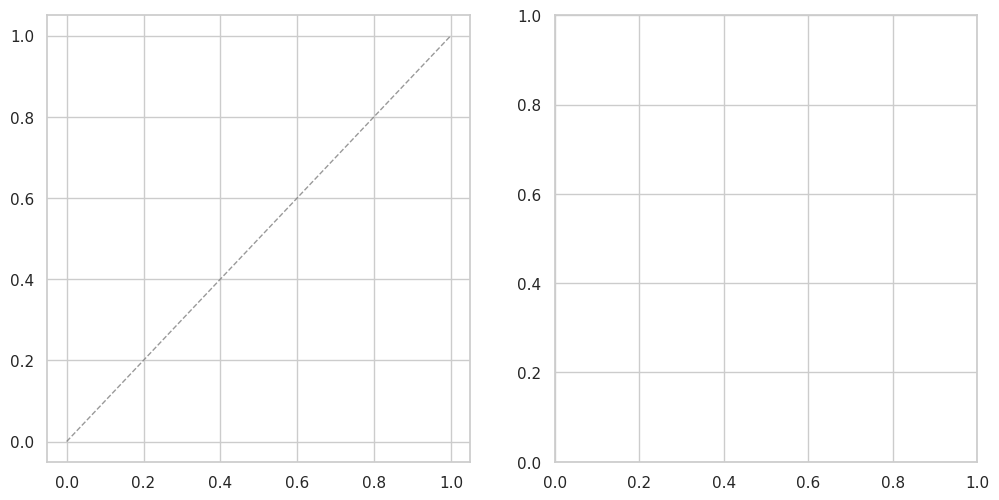

In [13]:
# ===============================================================
# ROC & PR (side-by-side) for LR-ElasticNet @ Youden(CV)
# Black line style, shorter titles, legend positions fixed
# ===============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5.8))

# ---- Left: ROC ----
ax = axes[0]
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1, alpha=0.8)

# Internal (solid black)
ax.plot(fpr_i, tpr_i, lw=2.2, color="black", label=f"Internal (AUROC={auroc_i:.3f})")
ax.scatter([fpr_i_op], [tpr_i_op], s=30, color="black", edgecolor="white", zorder=5)

# External (dashed black)
ax.plot(fpr_e, tpr_e, lw=2.2, color="black", linestyle="--", label=f"External (AUROC={auroc_e:.3f})")
ax.scatter([fpr_e_op], [tpr_e_op], s=30, color="black", edgecolor="white", zorder=5)

ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (LR-ElasticNet)")
ax.grid(True, which="both", ls=":", alpha=0.35)
ax.legend(loc="lower right", frameon=True)

# ---- Right: PR ----
ax = axes[1]
ax.plot(rec_i, prec_i, lw=2.2, color="black", label=f"Internal (AUPRC={auprc_i:.3f})")
ax.scatter([rec_i_op], [prec_i_op], s=32, color="black", edgecolor="white", linewidth=0.8, zorder=5)

ax.plot(rec_e, prec_e, lw=2.2, color="black", linestyle="--", label=f"External (AUPRC={auprc_e:.3f})")
ax.scatter([rec_e_op], [prec_e_op], s=32, color="black", edgecolor="white", linewidth=0.8, zorder=5)

ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve (LR-ElasticNet)")
ax.grid(True, which="both", ls=":", alpha=0.35)
ax.legend(loc="lower right", frameon=True)   # 👉 legend 오른쪽 아래

plt.tight_layout()
out_path = "LRElasticNet_ROC_PR_internal_external_bw.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

# Colab download
if files is not None:
    try:
        files.download(out_path)
    except Exception as e:
        print("Download skipped:", e)
else:
    print(f"Saved: {out_path}")


##8. Confusion matrix

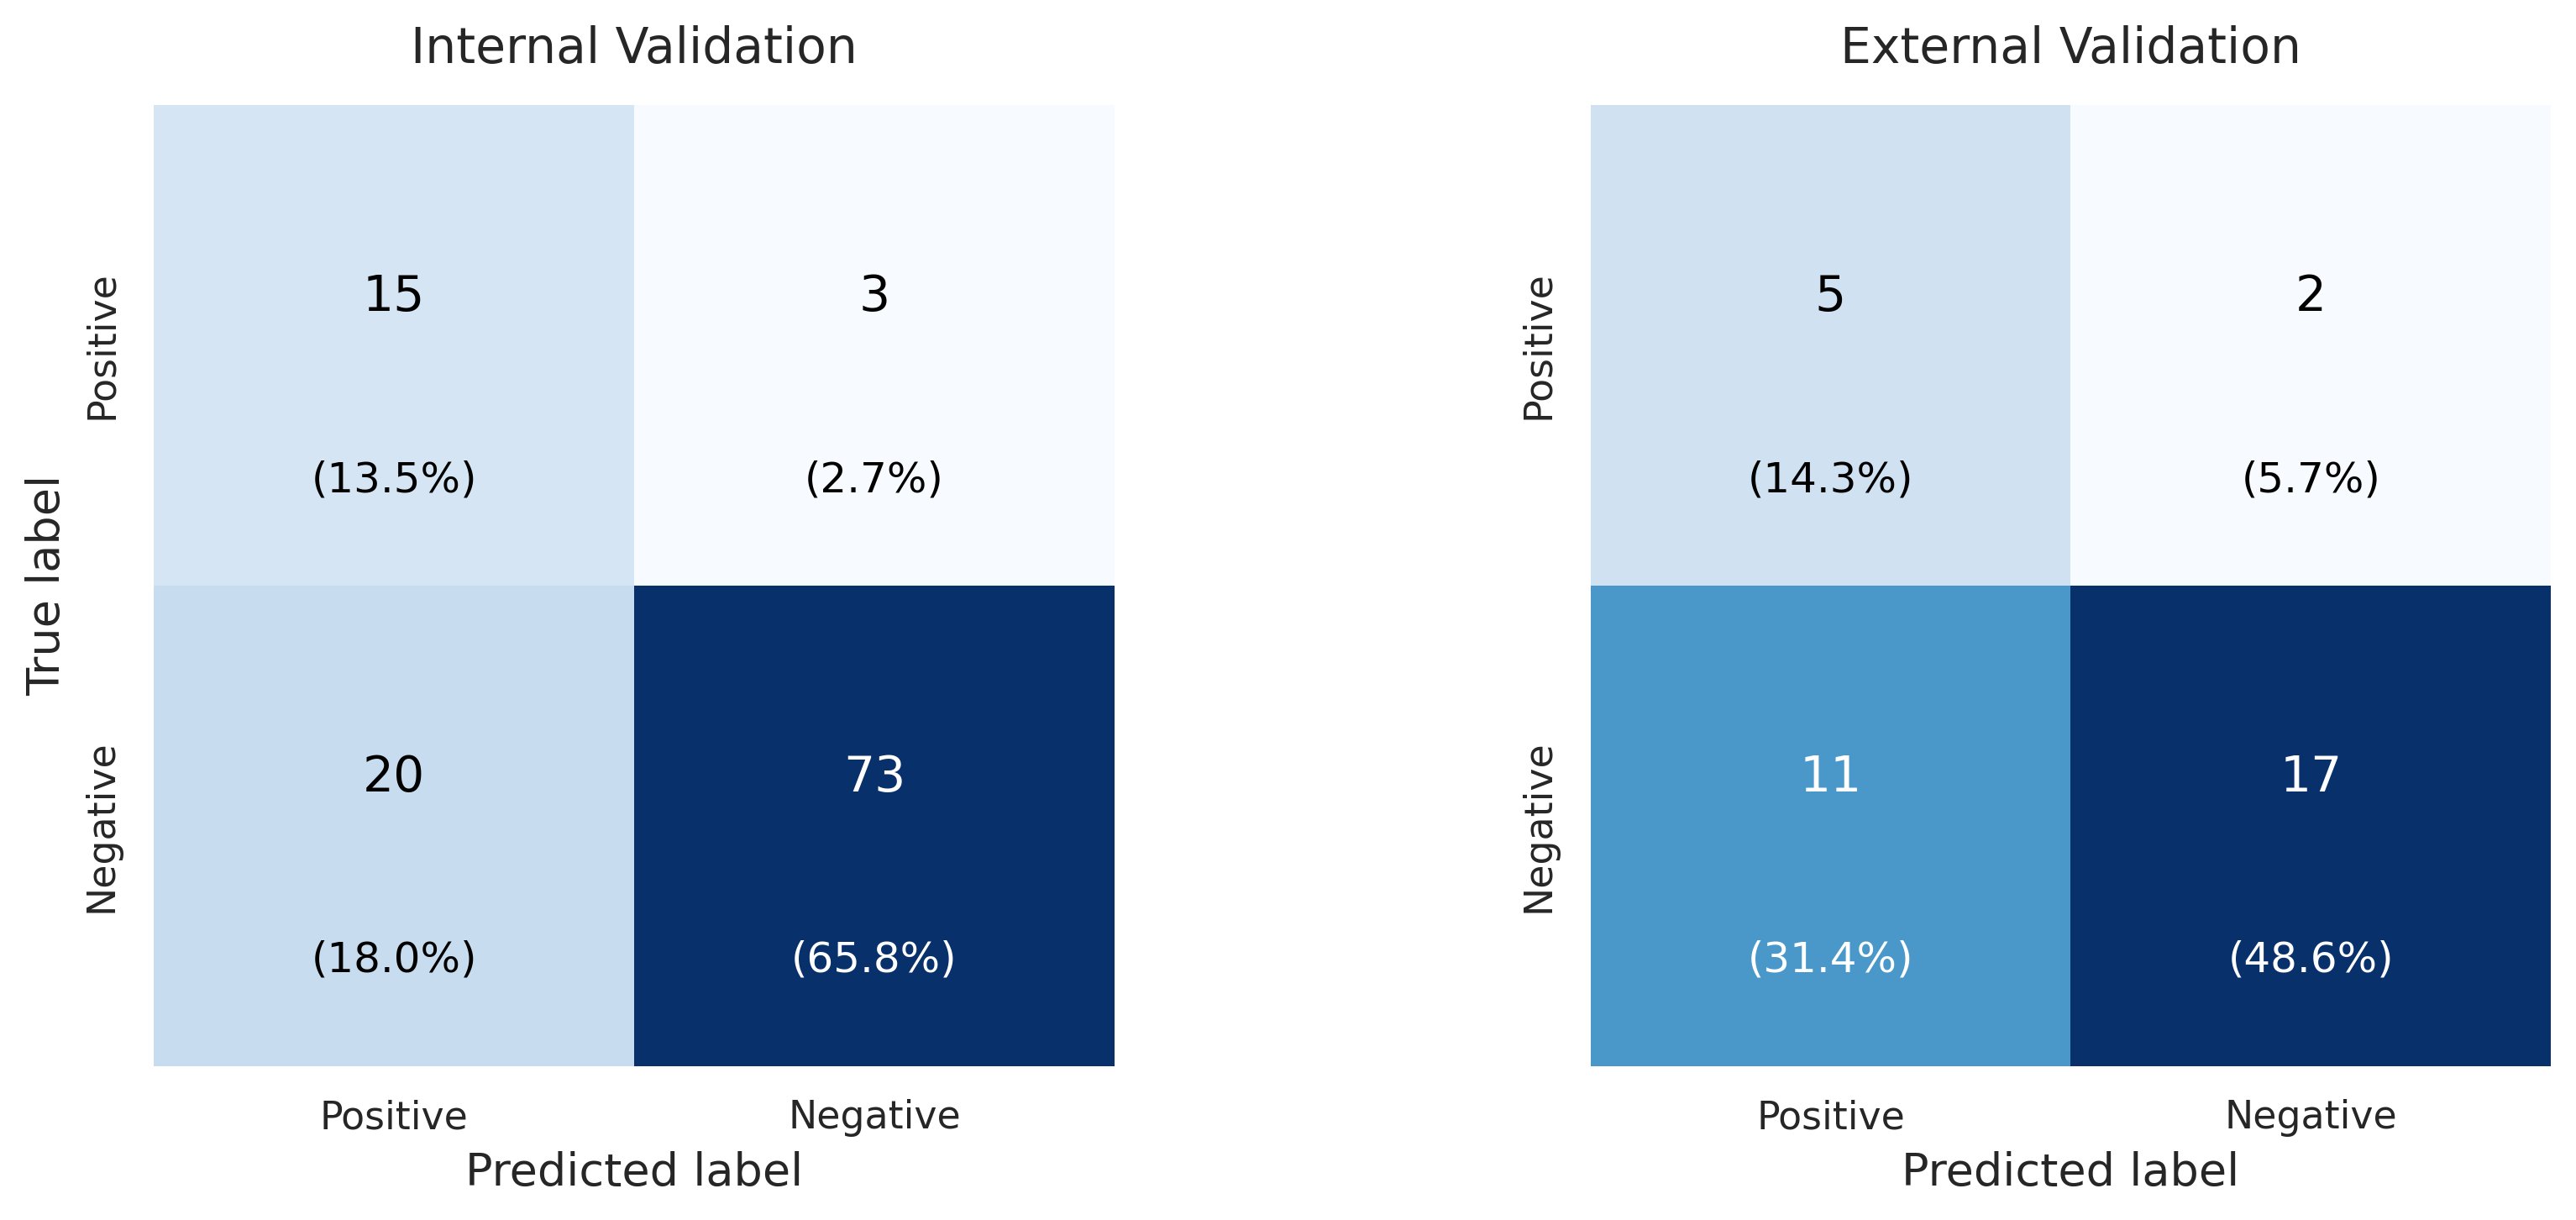

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# ===============================================================
# Confusion Matrices (Internal & External)
#  - Model: LR-ElasticNet
#  - Threshold: Youden(CV) fixed from valid_table
#  - Saves a 300 dpi figure with counts + percentages
# ===============================================================

# --- guards ---
need = ["best_models", "valid_table", "X_val", "y_val", "X_ext", "y_ext"]
for v in need:
    if v not in globals():
        raise NameError(f"{v} is not defined.")

# --- model & threshold (LR-ElasticNet @ Youden(CV)) ---
if "LR-ElasticNet" not in best_models:
    raise NameError("best_models does not contain 'LR-ElasticNet'.")

row = valid_table[(valid_table["Model"]=="LR-ElasticNet") & (valid_table["Method"]=="Youden(CV)")]
if row.empty:
    raise ValueError("LR-ElasticNet Youden(CV) row not found in valid_table.")
thr = float(row["Threshold"].iloc[0])

model = best_models["LR-ElasticNet"]

# --- predictions ---
p_int = model.predict_proba(X_val)[:, 1]
p_ext = model.predict_proba(X_ext)[:, 1]
y_int_pred = (p_int >= thr).astype(int)
y_ext_pred = (p_ext >= thr).astype(int)

# --- confusion matrices ---
# Rows: True [Positive, Negative], Cols: Pred [Positive, Negative]
labels = ["Positive", "Negative"]
cm_int = confusion_matrix(y_val, y_int_pred, labels=[1,0])
cm_ext = confusion_matrix(y_ext, y_ext_pred, labels=[1,0])

# --- helper plotter ---
def plot_cm(ax, cm, title):
    total = cm.sum()
    perc = (cm / total * 100.0) if total else np.zeros_like(cm, dtype=float)

    sns.heatmap(
        cm, annot=False, cmap="Blues", cbar=False, square=True,
        xticklabels=labels, yticklabels=labels,
        linewidths=0, ax=ax
    )

    # annotate counts + percentages
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = cm[i, j], perc[i, j]
            # readable text color
            color = "white" if cm[i, j] > cm.max() / 2 else "black"
            ax.text(j + 0.5, i + 0.40, f"{count}",
                    ha="center", va="center",
                    fontsize=14, color=color)
            ax.text(j + 0.5, i + 0.78, f"({pct:.1f}%)",
                    ha="center", va="center",
                    fontsize=12, color=color)

    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel("Predicted label", fontsize=13)
    ax.set_ylabel("True label", fontsize=13)
    ax.tick_params(labelsize=11)

# --- plot side by side ---
plt.rcParams.update({"figure.dpi": 300, "savefig.dpi": 300})
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

plot_cm(axes[0], cm_int, f"Internal Validation")
plot_cm(axes[1], cm_ext, f"External Validation")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("confusion_matrix_count+perc.png", dpi=300, bbox_inches="tight")
plt.show()

# download (Colab)
from google.colab import files
files.download("confusion_matrix_count+perc.png")


##9. SHAP analysis

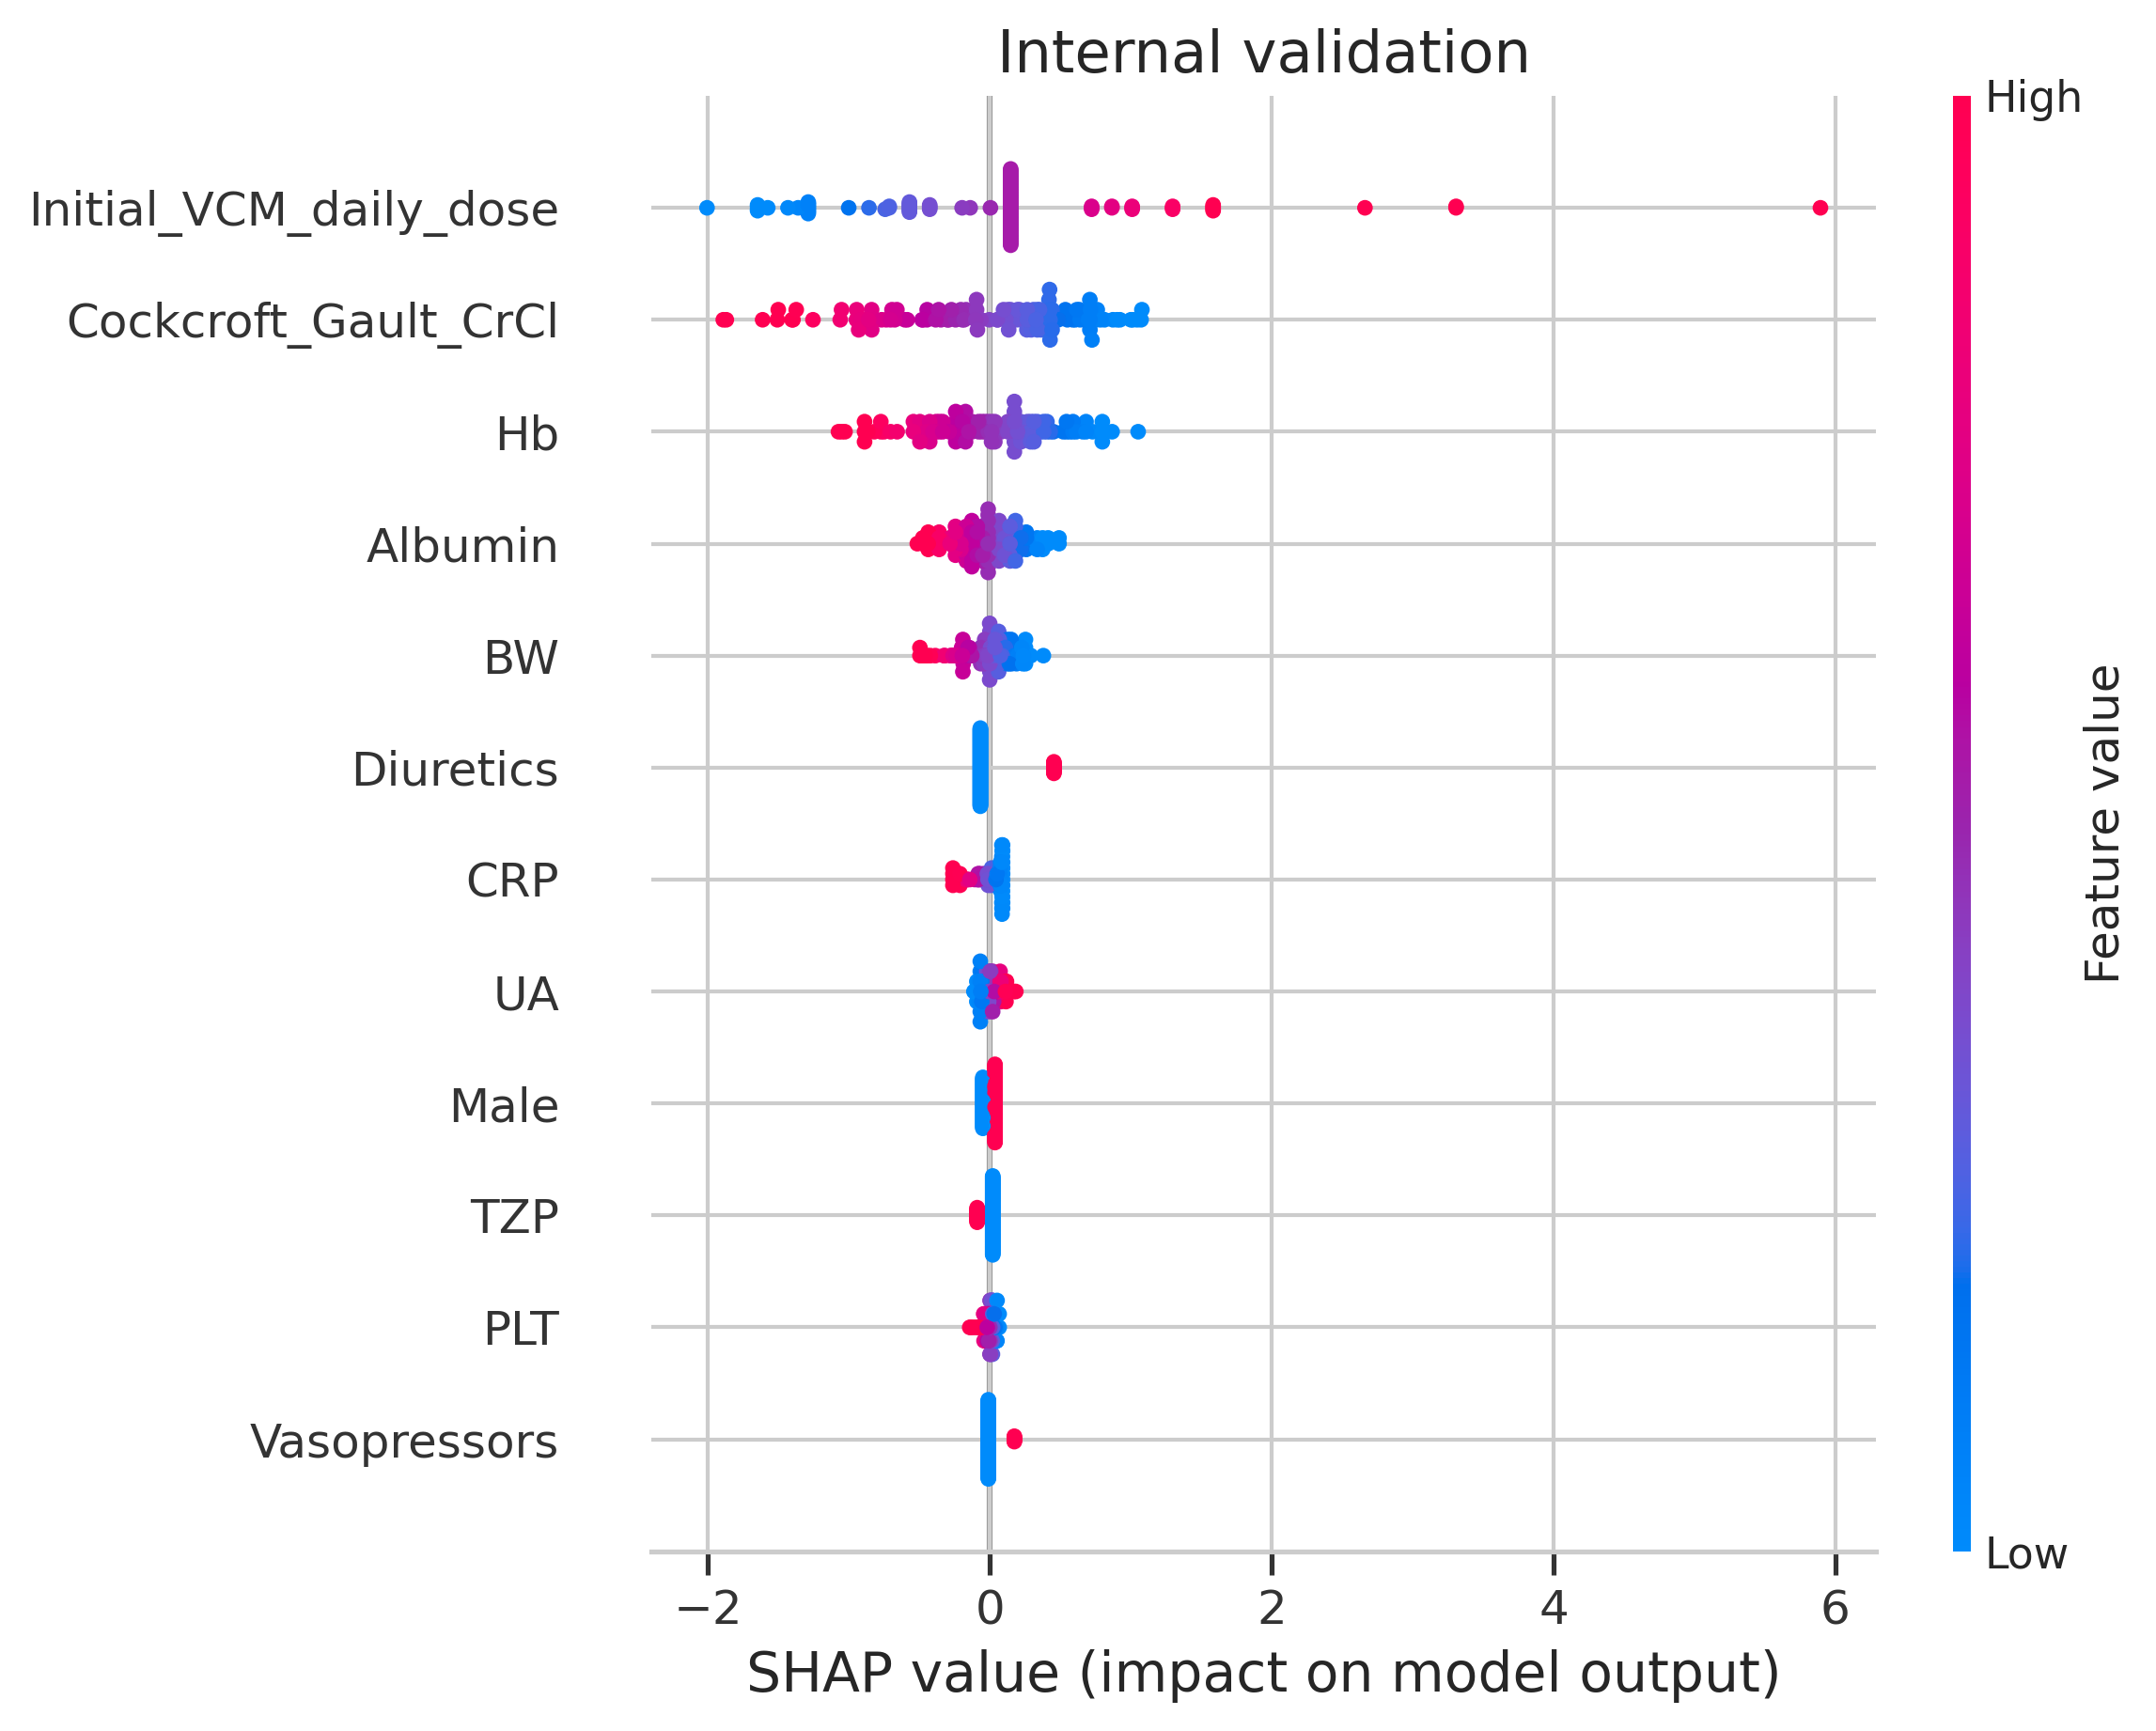

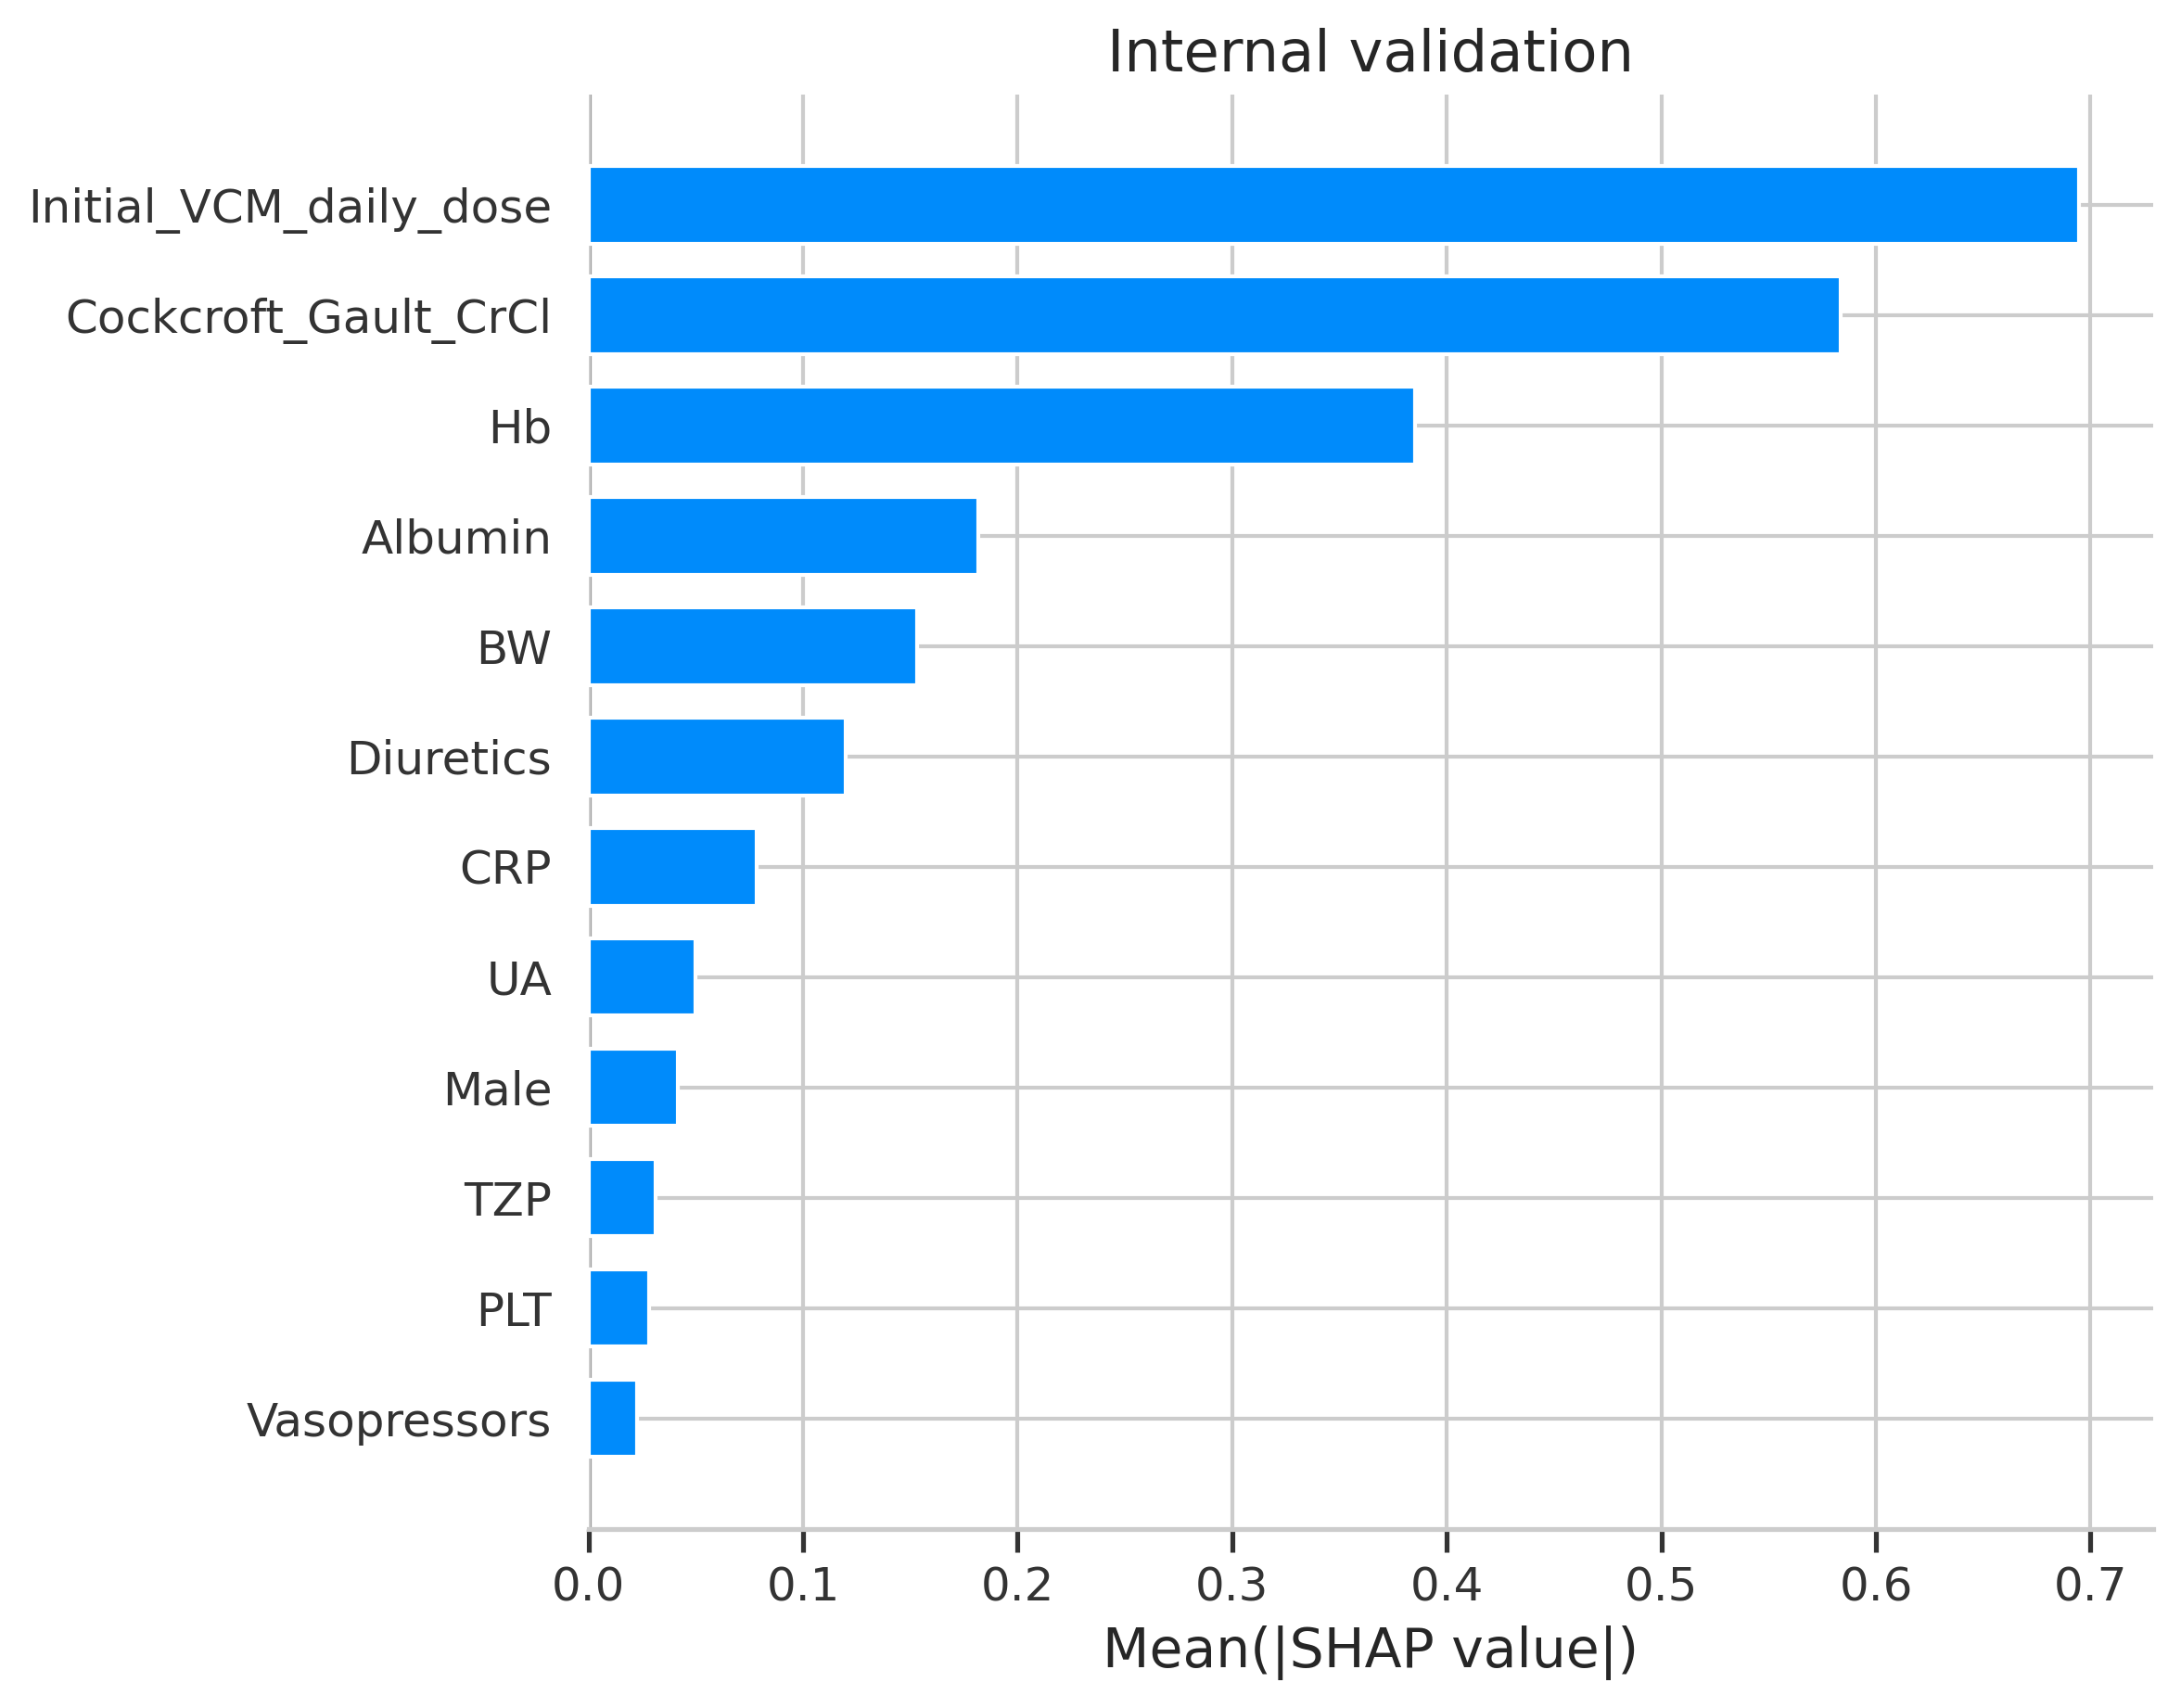

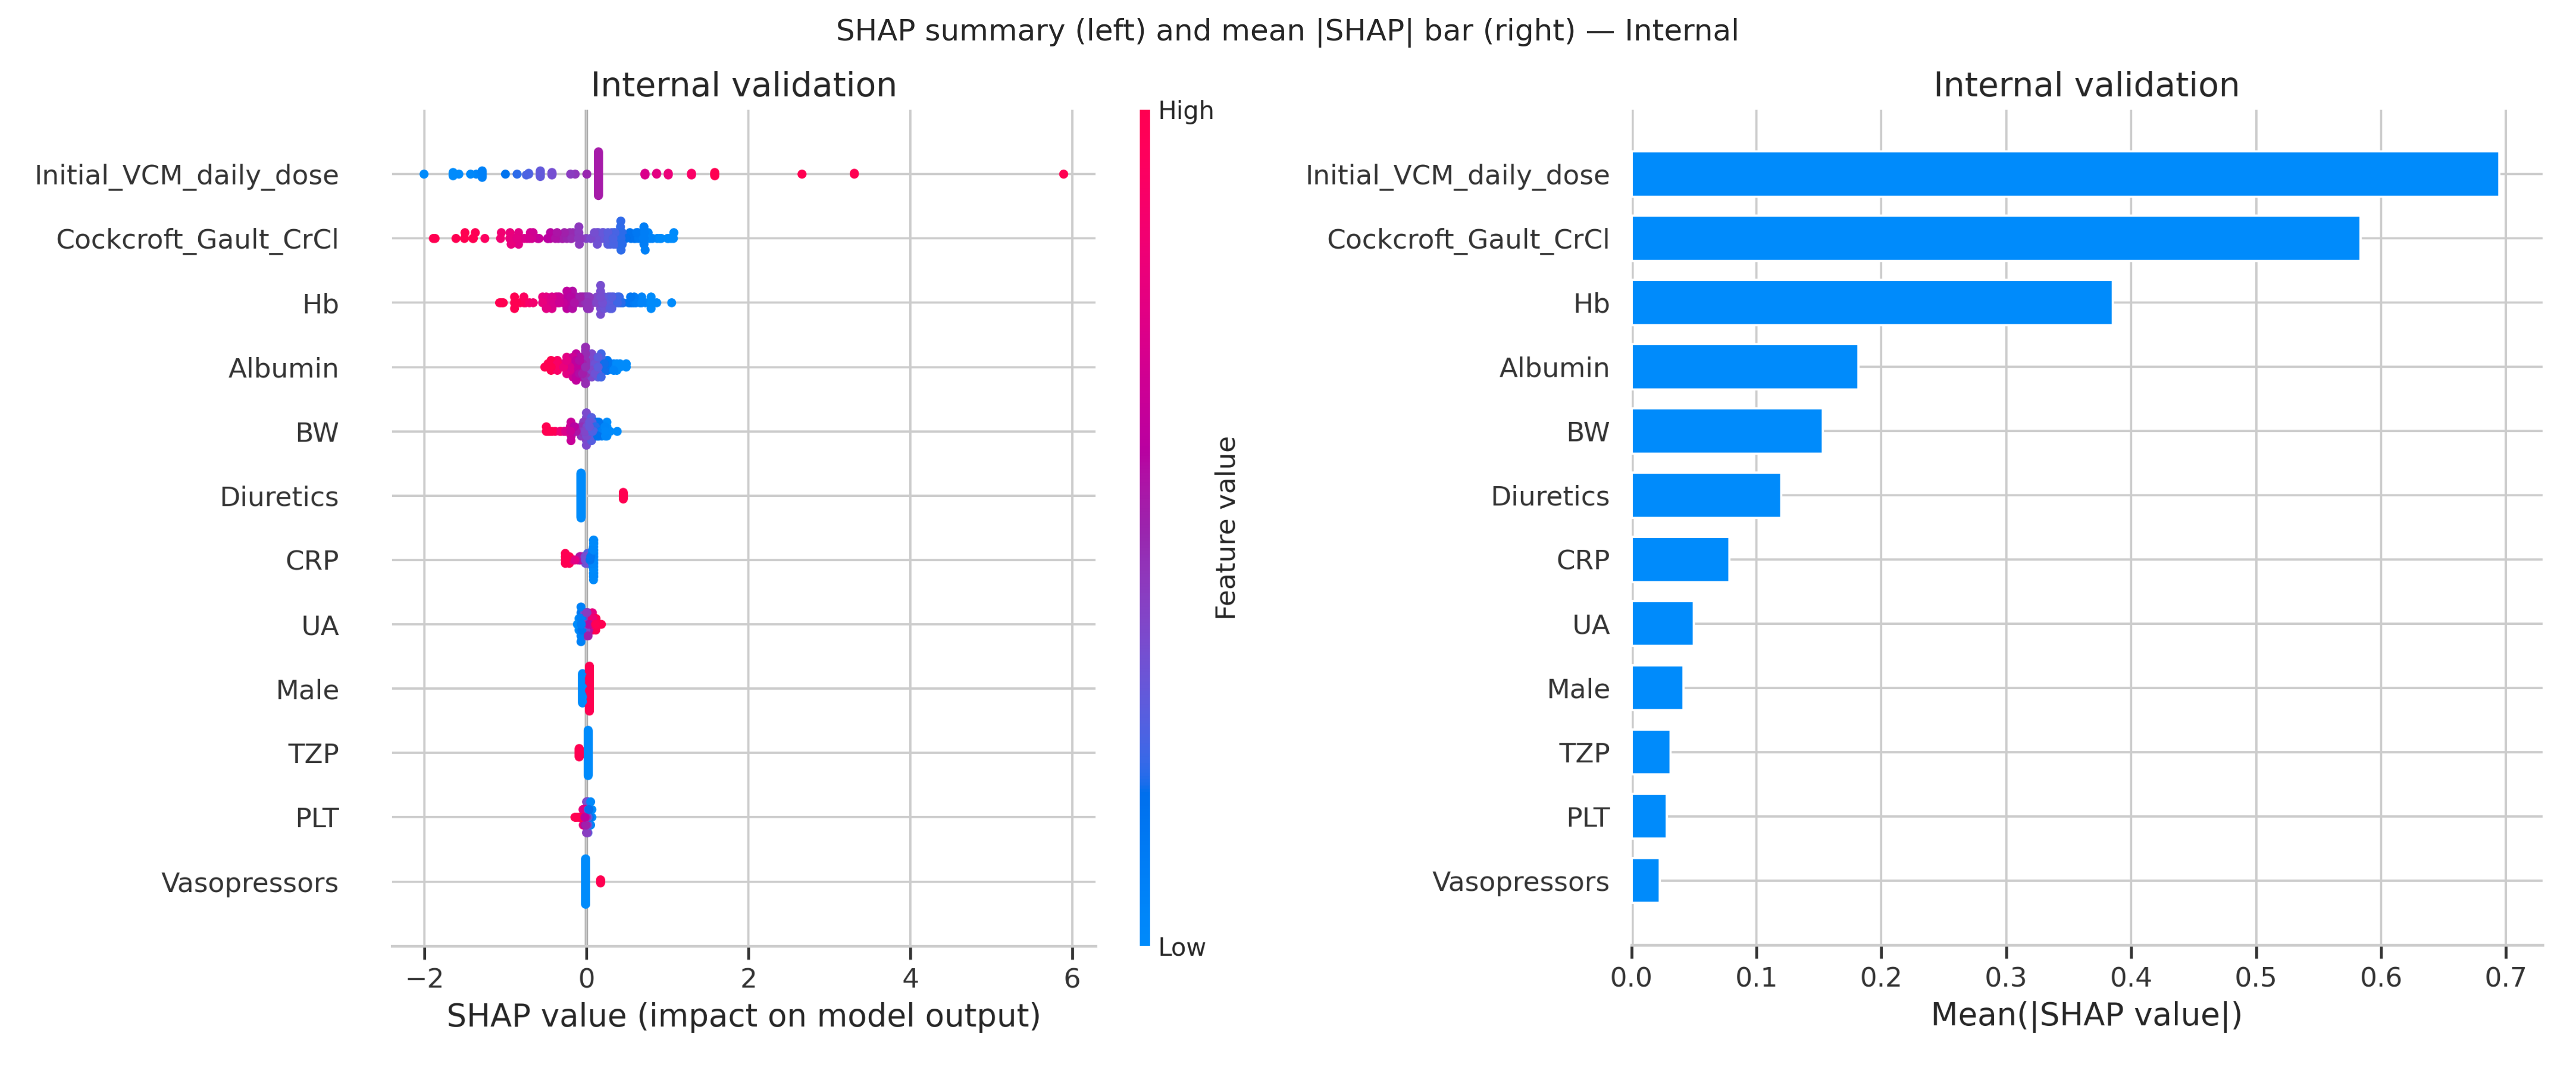

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

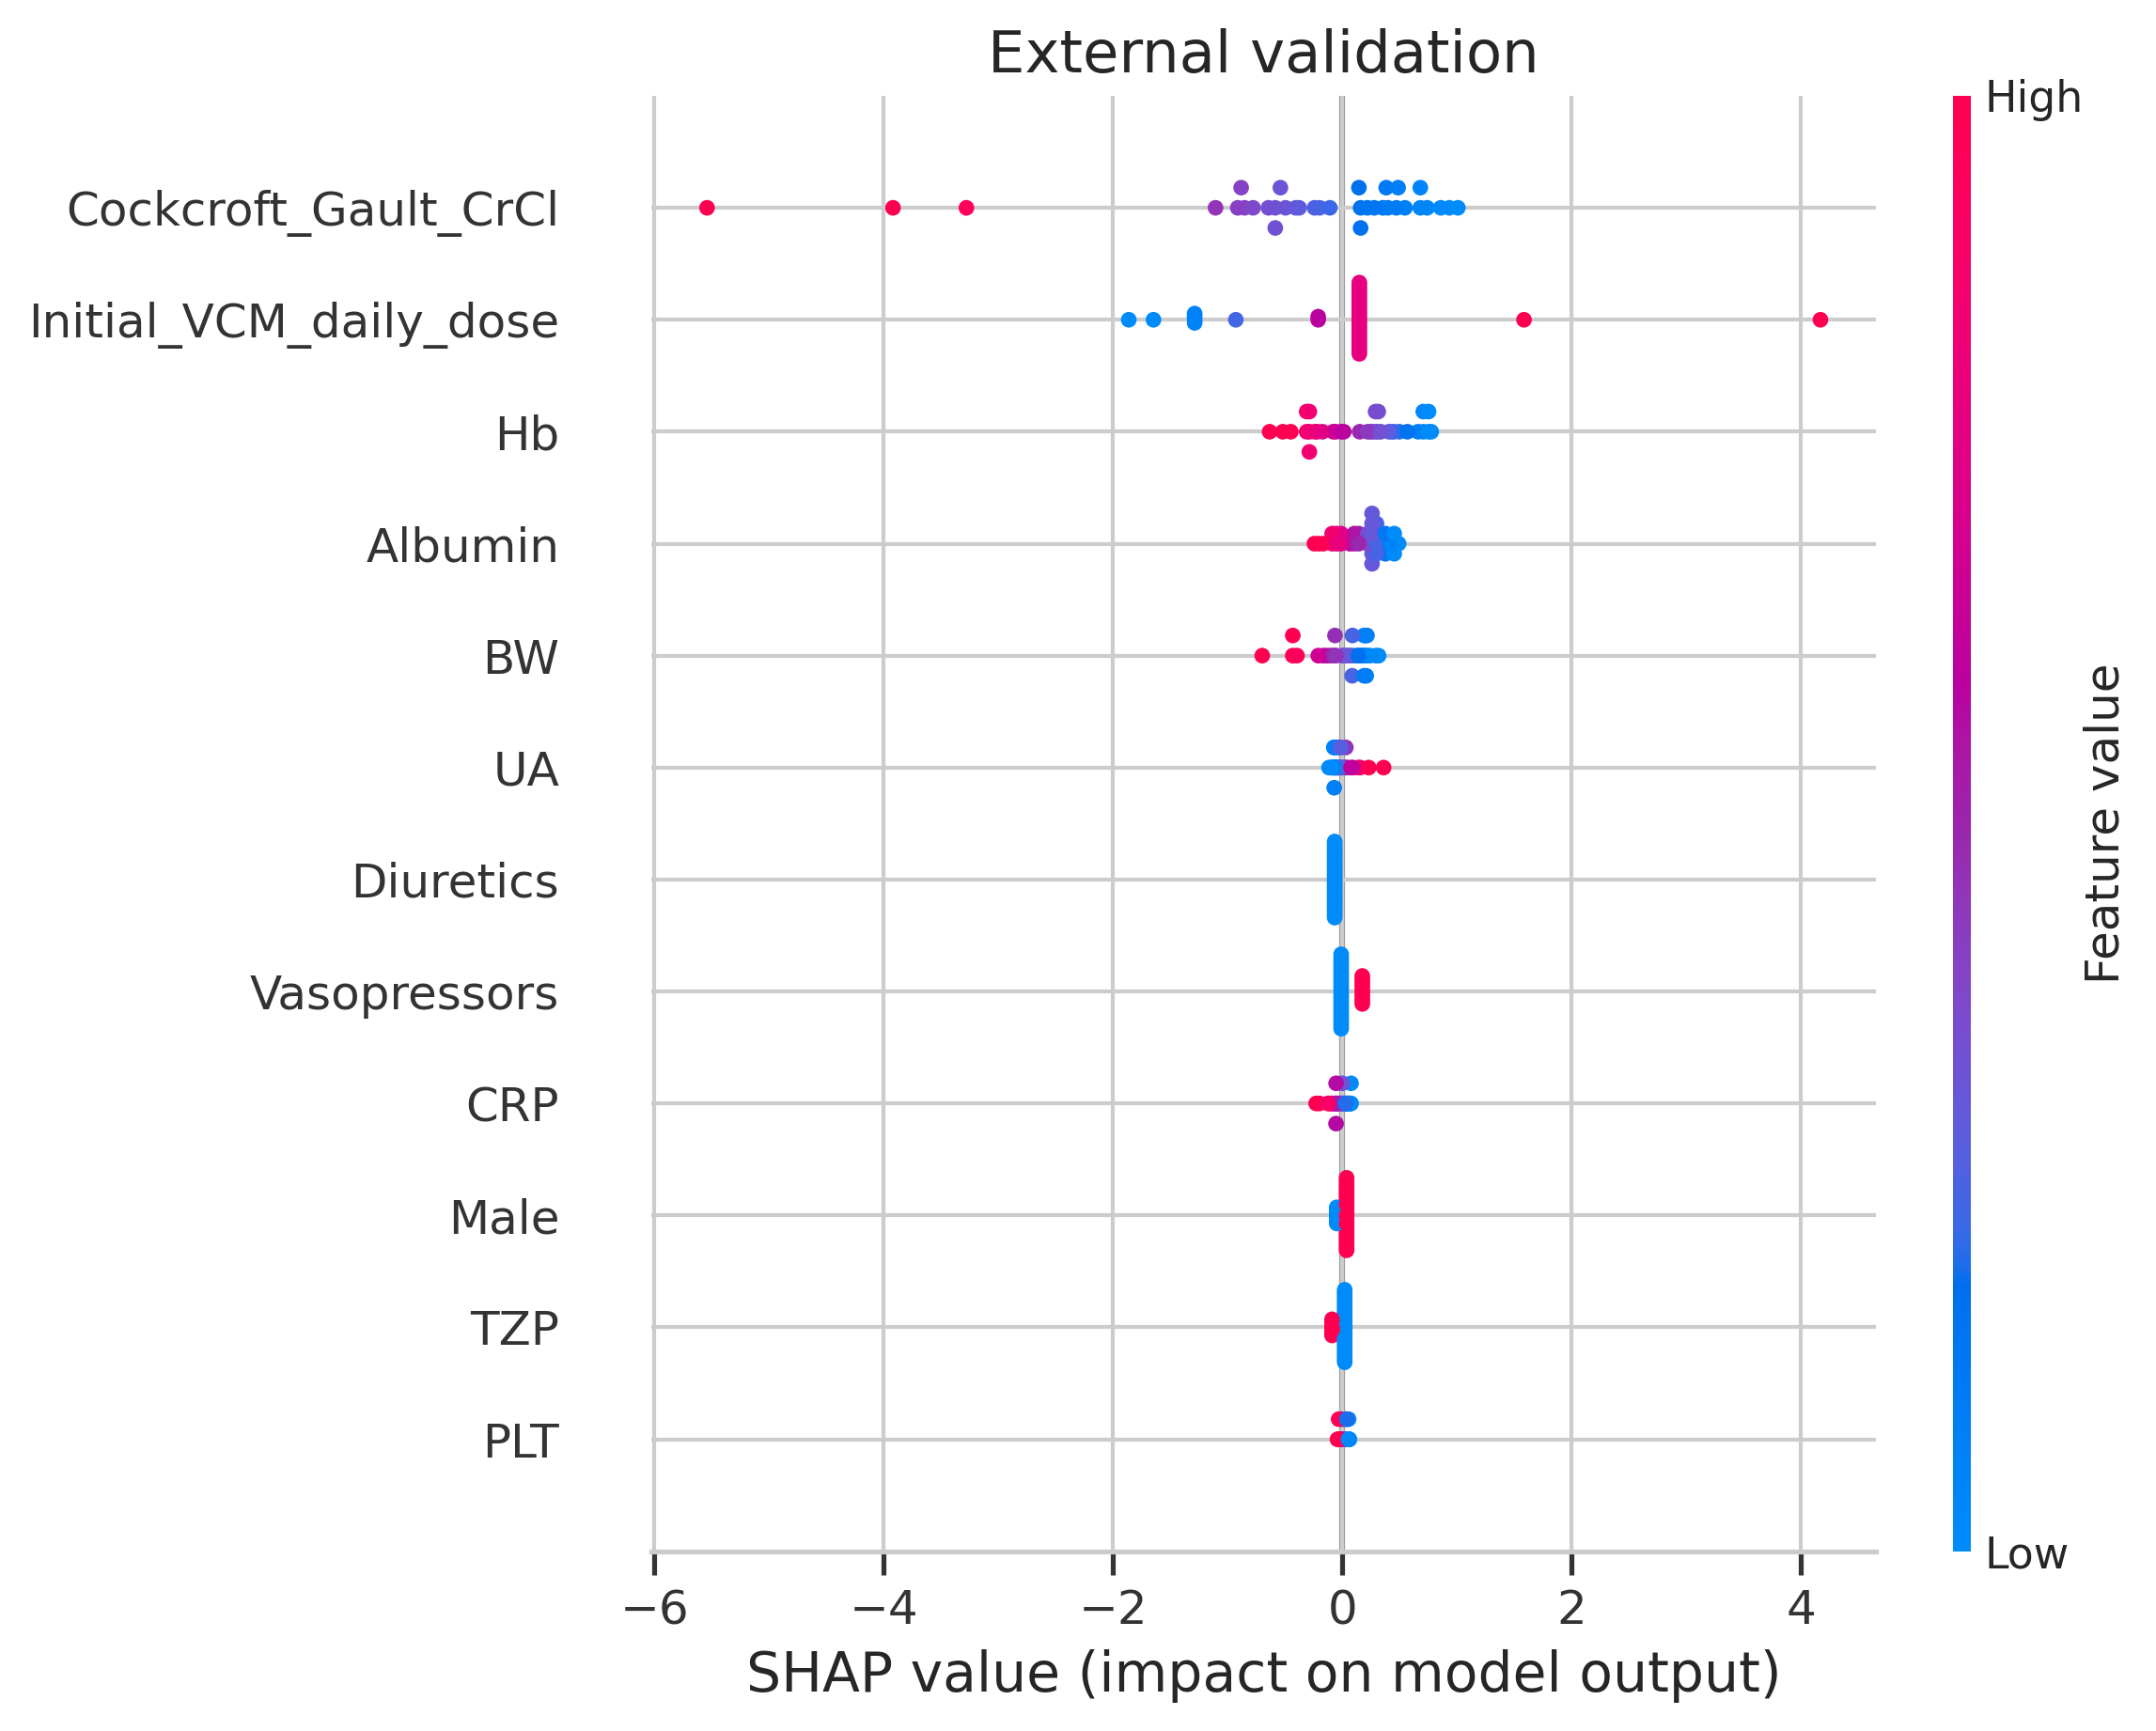

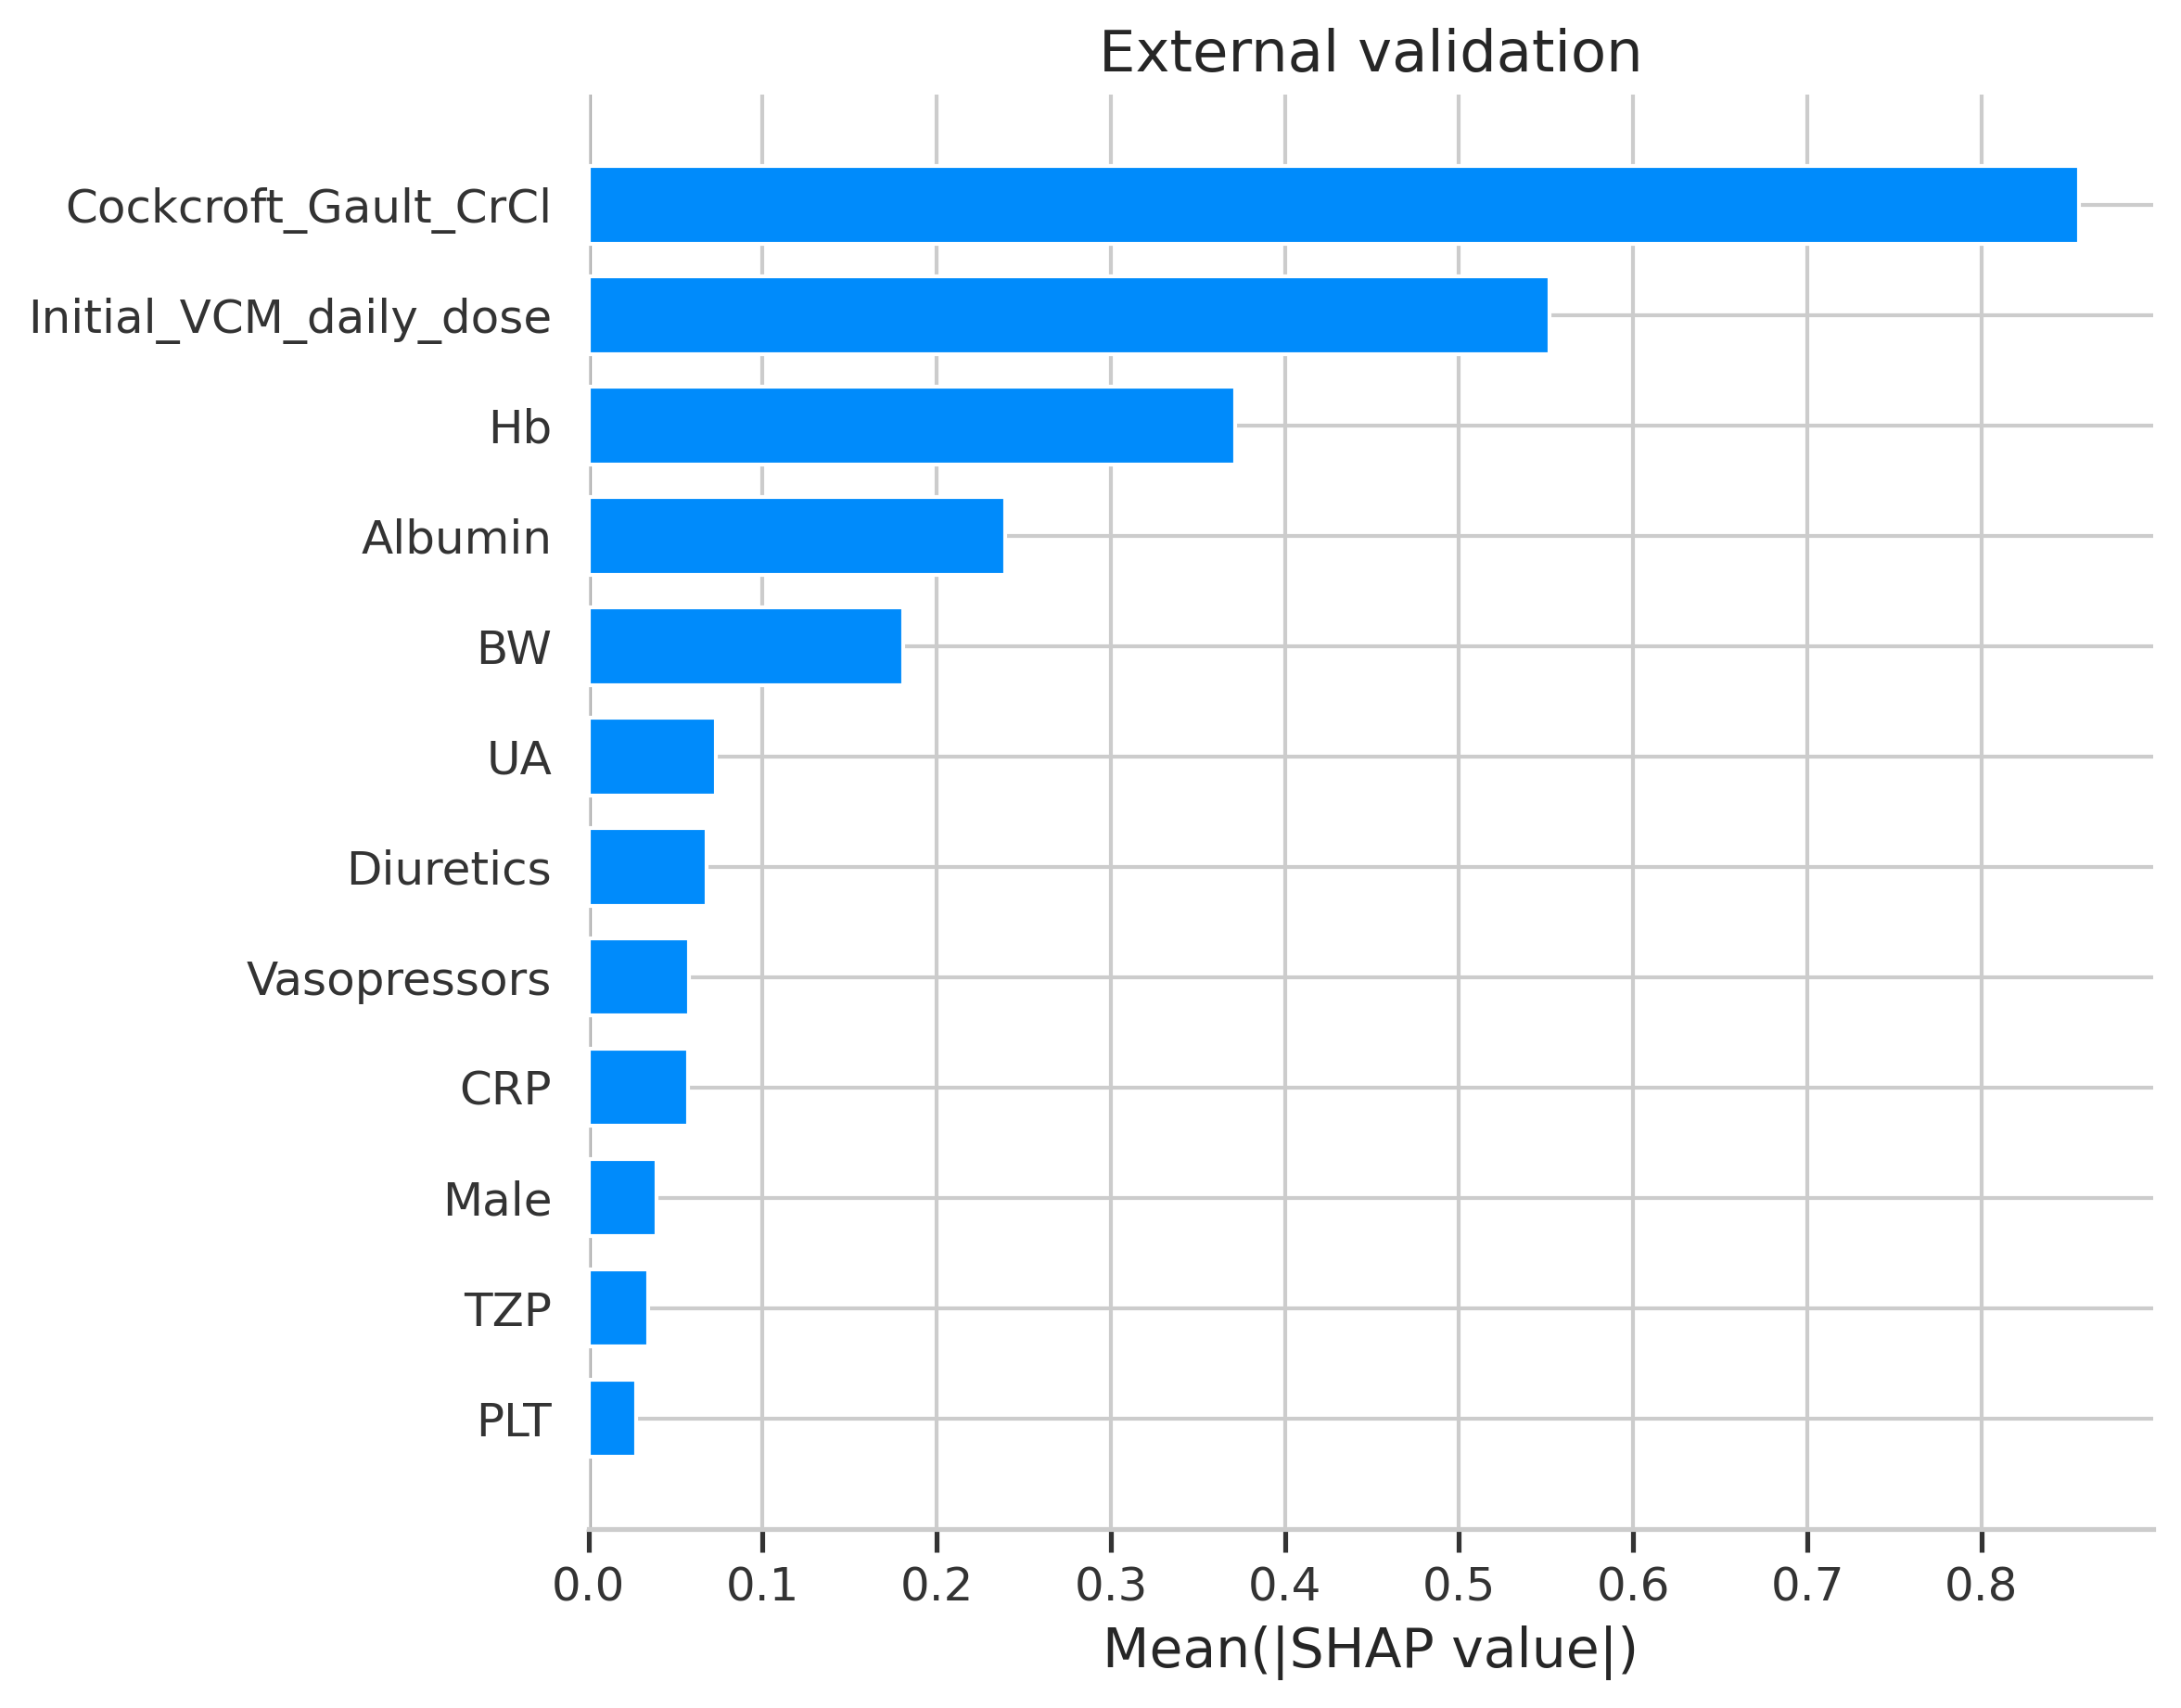

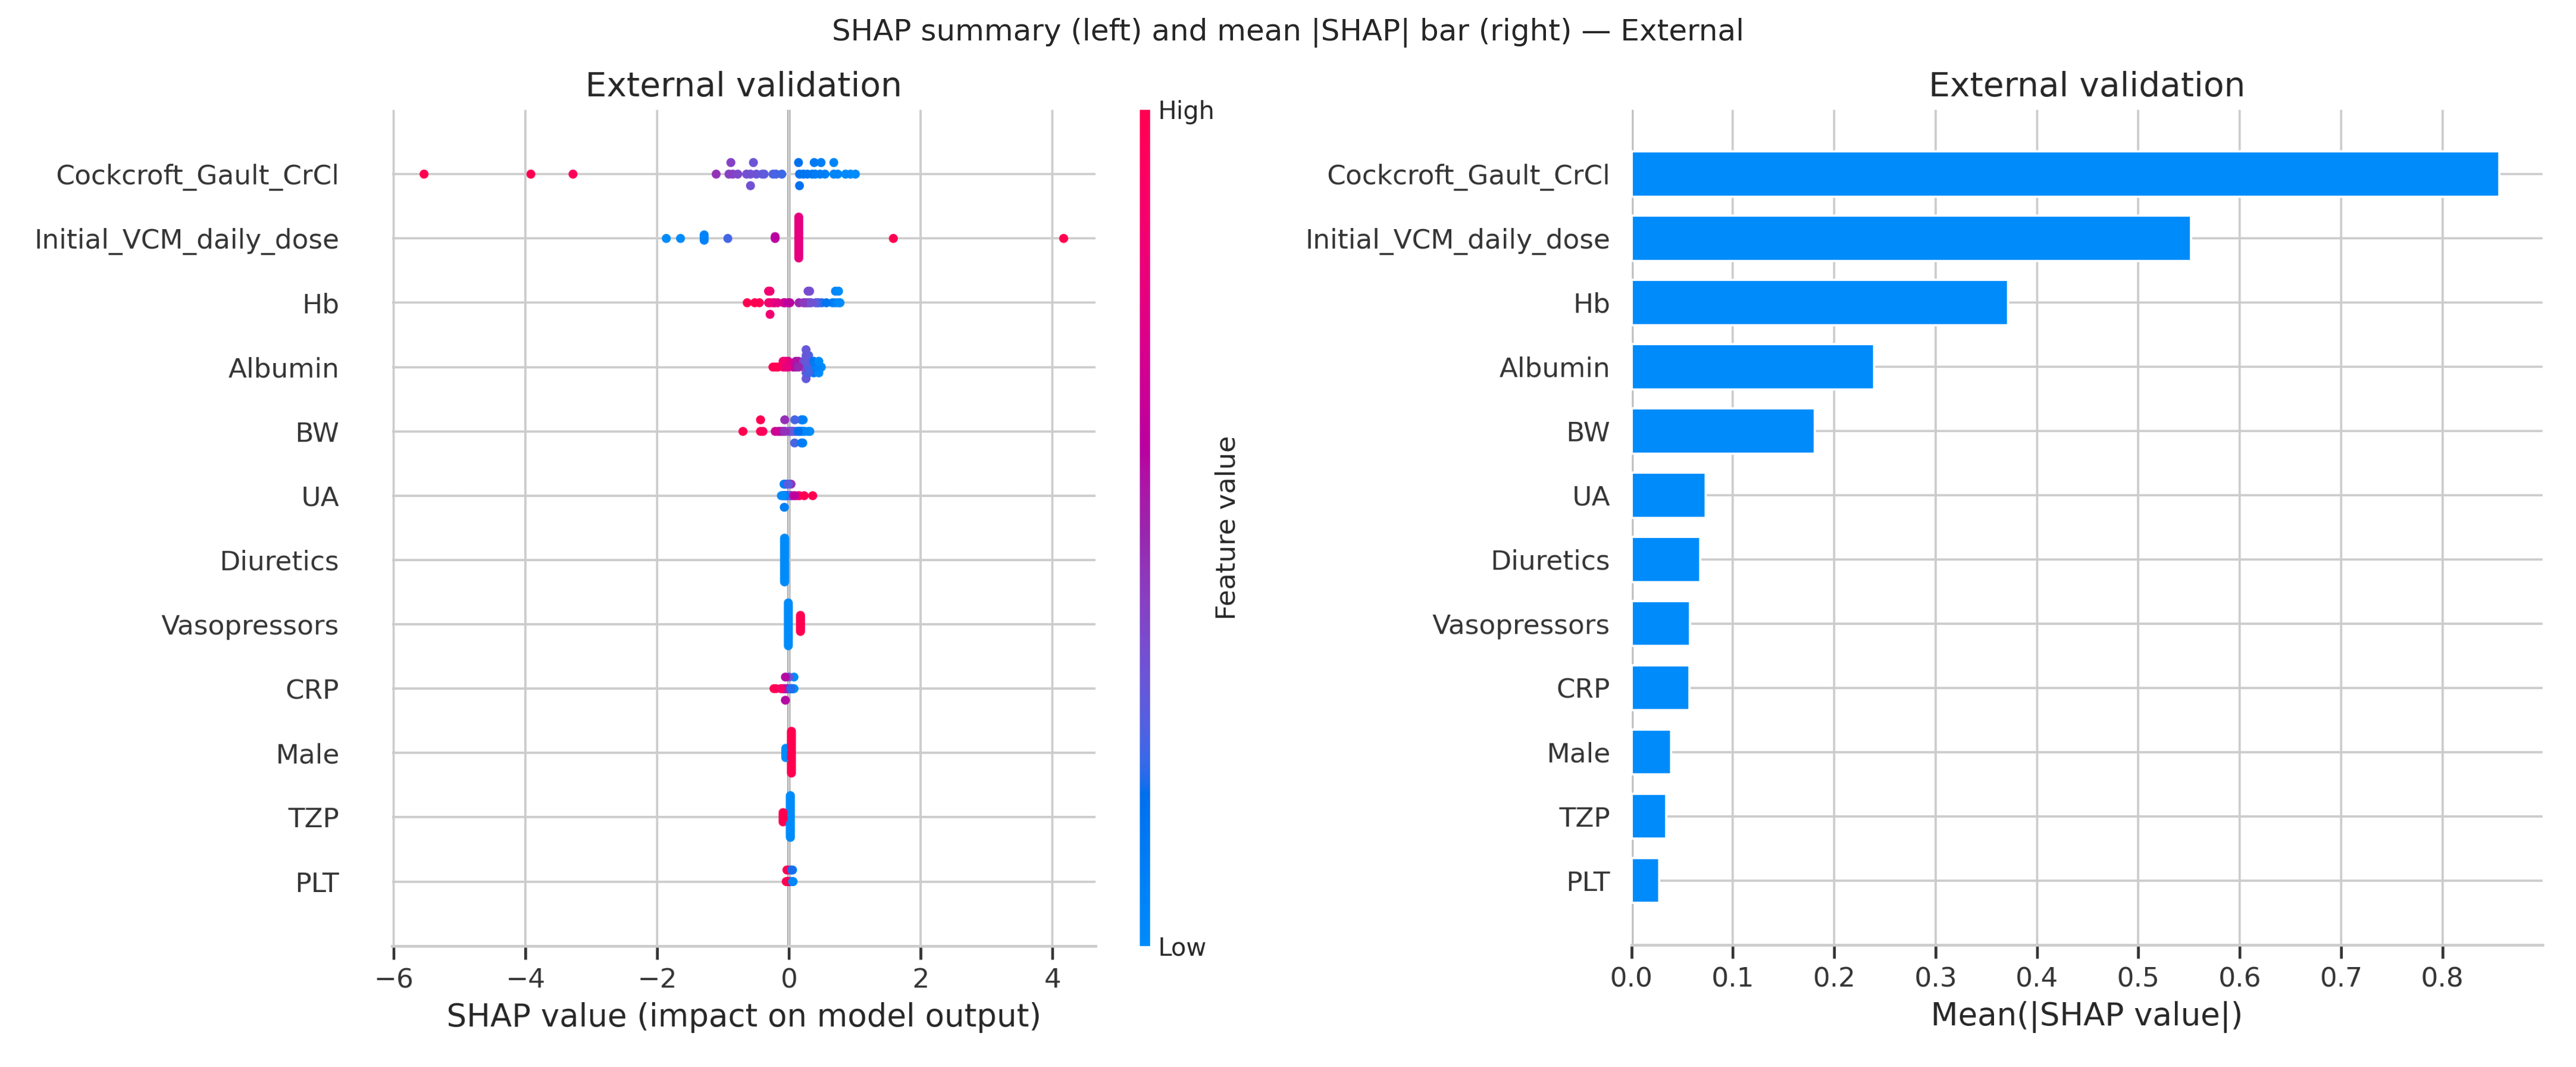

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

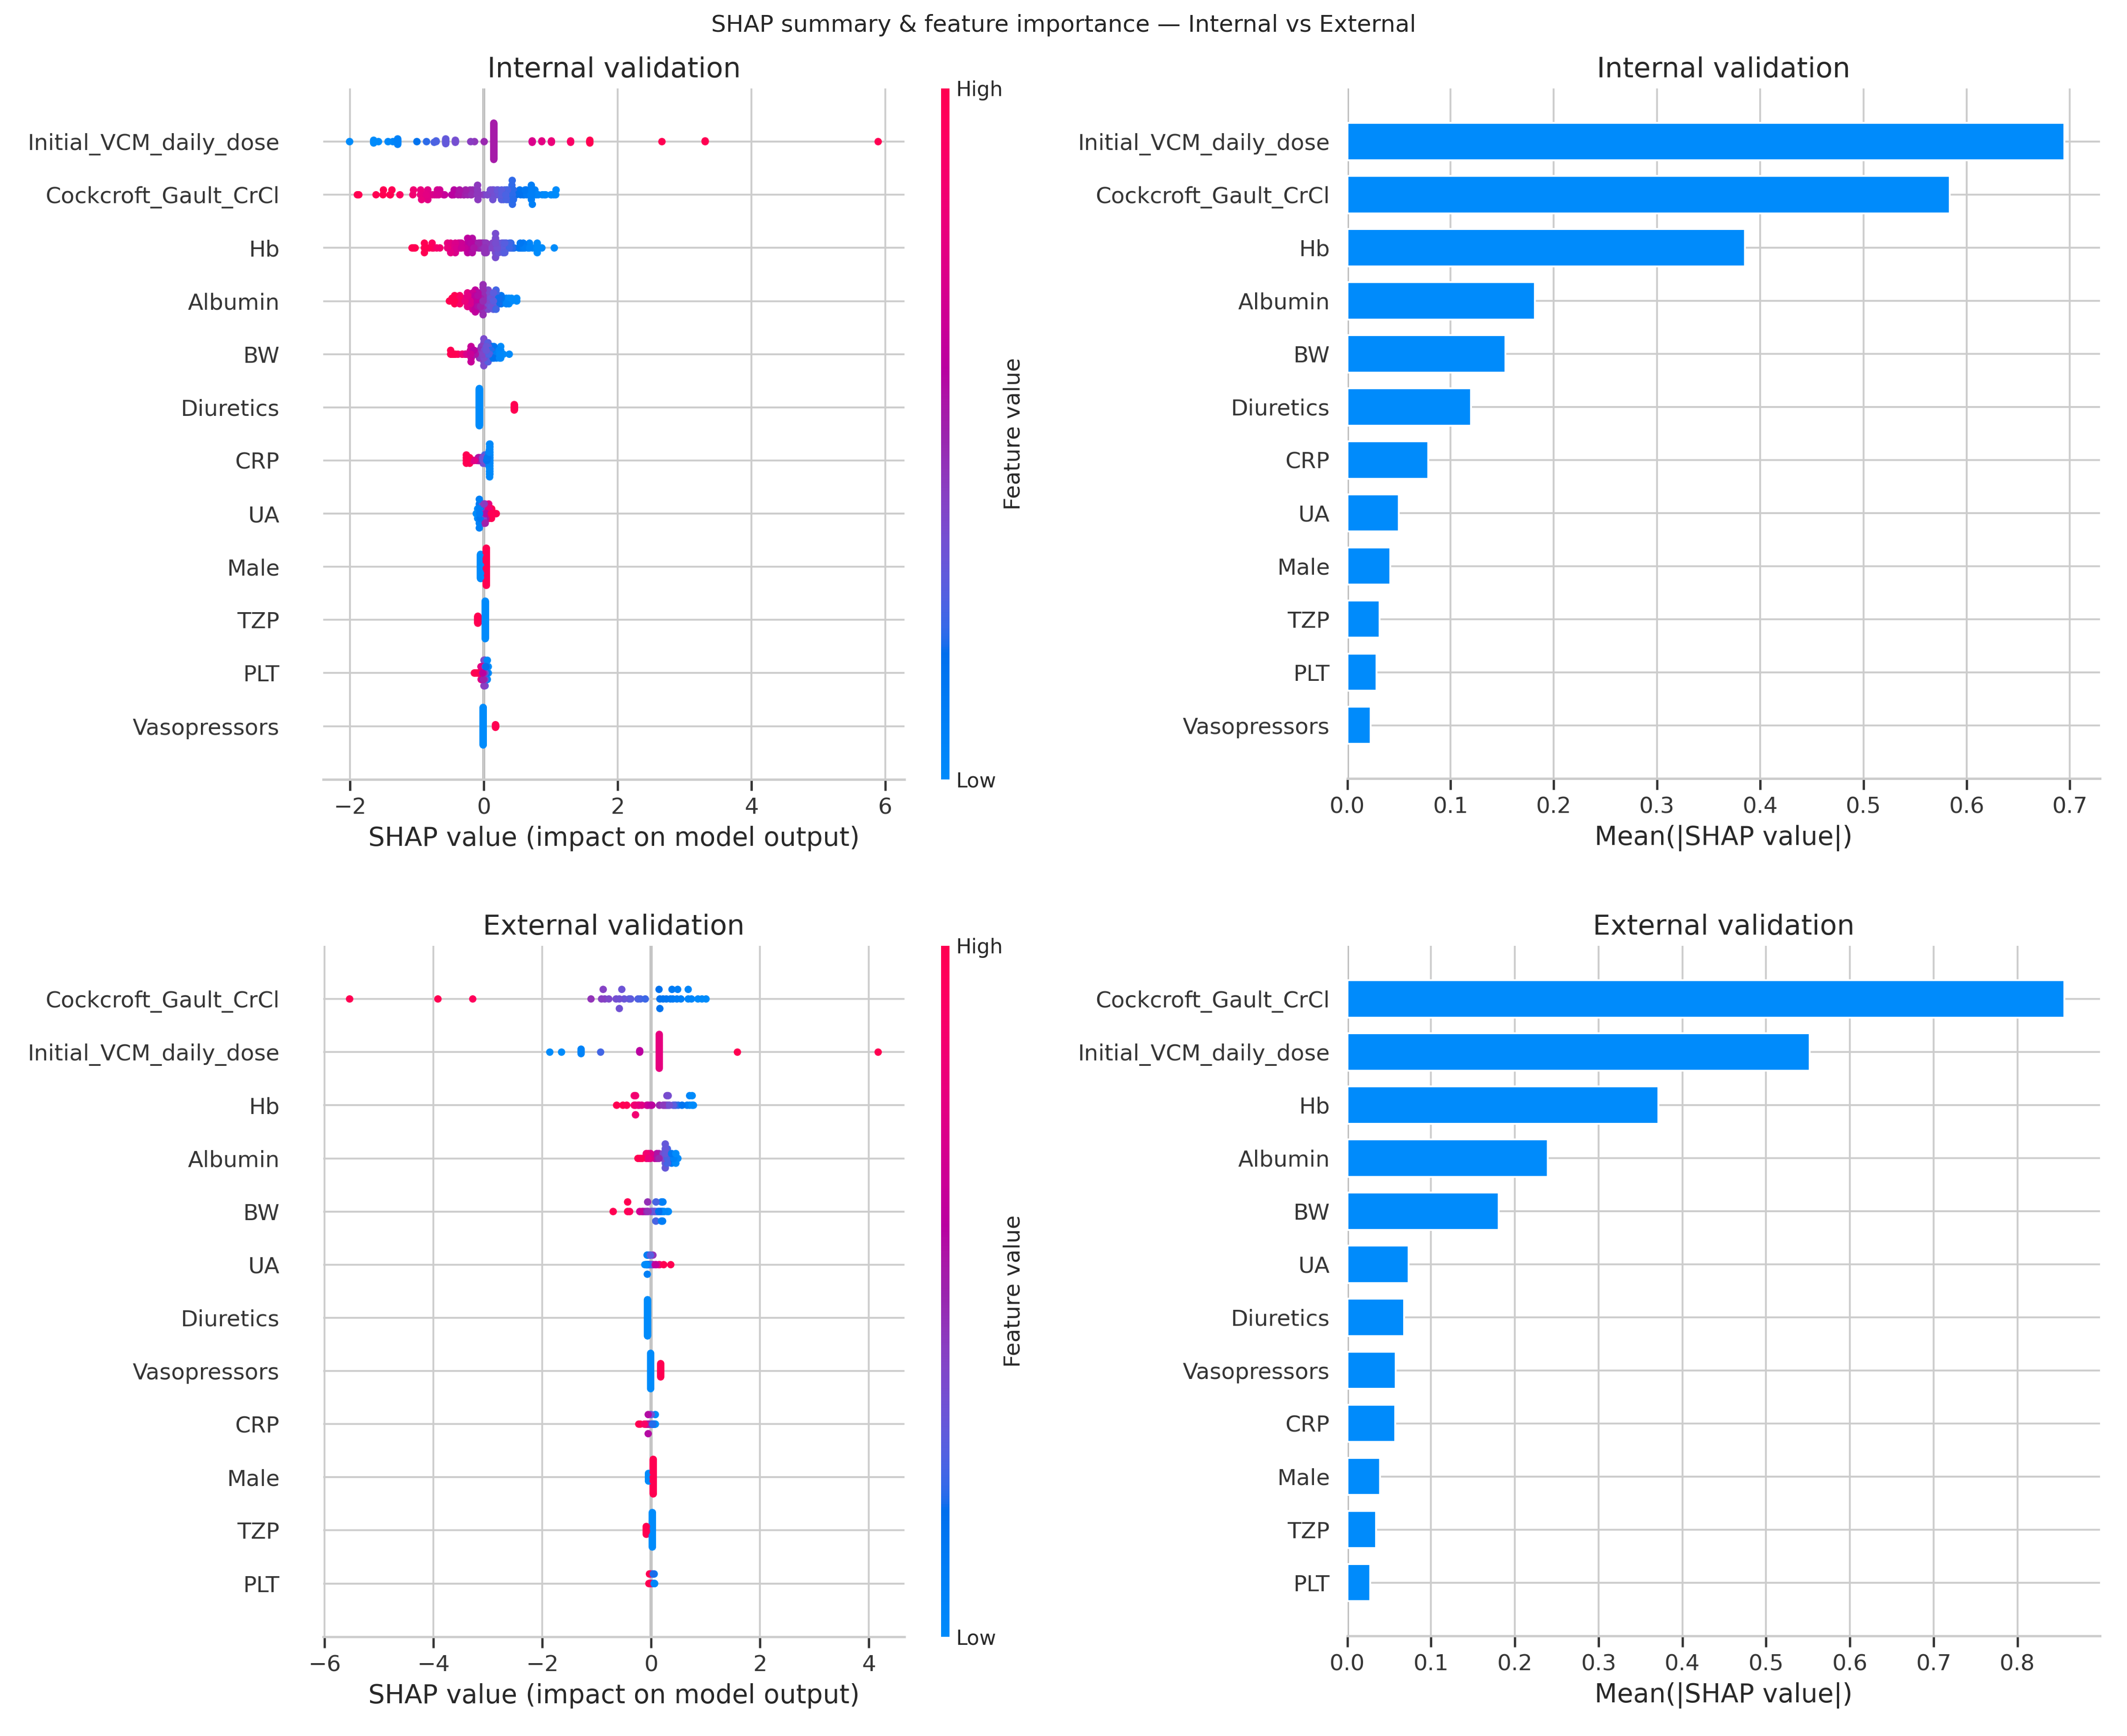

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# ===============================================================
# SHAP for LR-ElasticNet (Pipeline) + Publication-ready figures
# - Model: best_models["LR-ElasticNet"]
# - Threshold policy is irrelevant for SHAP; we explain the fitted model
# - Transforms X via pipeline (except final clf) to keep feature alignment
# - Exports: internal/external SHAP summary & bar (Top-16) and combined images
# ===============================================================



# ---------------- Guards ----------------
if "best_models" not in globals() or "LR-ElasticNet" not in best_models:
    raise NameError("best_models['LR-ElasticNet'] not found. Train/define the model first.")
if "X_val" not in globals() or "y_val" not in globals():
    raise NameError("X_val / y_val not found.")
external_present = ("X_ext" in globals())  # optional

# ---------------- Pick model & feature names ----------------
model = best_models["LR-ElasticNet"]

if "X_train" in globals() and hasattr(X_train, "columns"):
    feat_names = list(X_train.columns)
elif hasattr(X_val, "columns"):
    feat_names = list(X_val.columns)
else:
    raise ValueError("Cannot resolve feature names (need X_train.columns or X_val.columns).")

# ---------------- Split transformer / final estimator ----------------
if isinstance(model, Pipeline):
    if len(model.steps) < 1:
        raise ValueError("Pipeline is empty.")
    transformer = model[:-1]  # everything except final classifier
    final_est = model[-1]     # LogisticRegression (elasticnet)
else:
    transformer = None
    final_est = model

# ---------------- Transform helper (keeps column names) ----------------
def transform_features(X_df, transformer, feat_names):
    if transformer is None or len(getattr(transformer, "steps", [])) == 0:
        Z = X_df.values
    else:
        Z = transformer.transform(X_df)
    # StandardScaler is 1:1 mapping → columns preserved
    cols = feat_names if Z.shape[1] == len(feat_names) else [f"f{i}" for i in range(Z.shape[1])]
    return pd.DataFrame(Z, columns=cols, index=X_df.index)

# ---------------- Build transformed matrices ----------------
Xv_t = transform_features(X_val, transformer, feat_names)

Xe_t = None
if external_present:
    Xe_t = transform_features(X_ext, transformer, feat_names)

# ---------------- Background for LinearExplainer ----------------
# small random subset of internal transformed data
rng = np.random.default_rng(42)
bg_idx = rng.choice(len(Xv_t), size=min(200, len(Xv_t)), replace=False)
background = Xv_t.iloc[bg_idx, :].values

# ---------------- SHAP computation (single explainer) ----------------
# Note: LinearExplainer returns SHAP in log-odds space for logistic models.
# (순위/기여도 해석엔 문제 없음)
try:
    expl = shap.LinearExplainer(final_est, background, feature_perturbation="interventional")
    sv_v = expl.shap_values(Xv_t.values)  # (n_internal, n_features)
    if external_present and Xe_t is not None:
        sv_e = expl.shap_values(Xe_t.values)
except Exception as e:
    raise RuntimeError(f"Failed to compute SHAP: {e}")

# ===============================================================
# Plotting helpers (Top-K)
# ===============================================================
TOP = 12  # number of top features to display

def select_topk_by_mean_abs(sv, Xdf, k):
    mean_abs = np.mean(np.abs(sv), axis=0)
    order = np.argsort(mean_abs)[::-1]
    keep_idx = order[:min(k, len(order))]
    return sv[:, keep_idx], Xdf.iloc[:, keep_idx], keep_idx, mean_abs[keep_idx]

def plot_shap_dot(sv, Xdf, out_png, title=""):
    nfeat = Xdf.shape[1]
    fig_h = min(max(0.55 * nfeat + 4, 8), 22)
    plt.figure(figsize=(8.5, fig_h), dpi=300)
    shap.summary_plot(sv, Xdf, plot_type='dot', show=False, max_display=nfeat)
    ax = plt.gca()
    ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    if title:
        ax.set_title(title, fontsize=15)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()

def plot_shap_bar(sv, Xdf, out_png, title=""):
    nfeat = Xdf.shape[1]
    fig_h = min(max(0.45 * nfeat + 4, 6), 20)
    plt.figure(figsize=(8.5, fig_h), dpi=300)
    shap.summary_plot(sv, Xdf, plot_type='bar', show=False, max_display=nfeat)
    ax = plt.gca()
    ax.set_xlabel("Mean(|SHAP value|)", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    if title:
        ax.set_title(title, fontsize=15)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()

# Image compose helpers
def combine_side_by_side(left_path, right_path, out_png, title=None, gap=60):
    img_left = Image.open(left_path).convert("RGB")
    img_right = Image.open(right_path).convert("RGB")
    new_h = max(img_left.height, img_right.height)
    new_w = img_left.width + gap + img_right.width
    canvas = Image.new("RGB", (new_w, new_h), (255, 255, 255))
    y_l = (new_h - img_left.height) // 2
    y_r = (new_h - img_right.height) // 2
    canvas.paste(img_left, (0, y_l))
    canvas.paste(img_right, (img_left.width + gap, y_r))
    canvas.save(out_png)
    # preview
    plt.figure(figsize=(new_w/300, new_h/300), dpi=300)
    plt.imshow(canvas); plt.axis("off")
    if title: plt.title(title, fontsize=12)
    plt.tight_layout(); plt.show()
    files.download(out_png)

def stack_vertical(top_path, bottom_path, out_png, title=None, gap=80):
    img_top = Image.open(top_path).convert("RGB")
    img_bottom = Image.open(bottom_path).convert("RGB")
    new_w = max(img_top.width, img_bottom.width)
    new_h = img_top.height + gap + img_bottom.height
    canvas = Image.new("RGB", (new_w, new_h), (255, 255, 255))
    canvas.paste(img_top, ((new_w - img_top.width)//2, 0))
    canvas.paste(img_bottom, ((new_w - img_bottom.width)//2, img_top.height + gap))
    canvas.save(out_png)
    # preview
    plt.figure(figsize=(new_w/300, new_h/300), dpi=300)
    plt.imshow(canvas); plt.axis("off")
    if title: plt.title(title, fontsize=12)
    plt.tight_layout(); plt.show()
    files.download(out_png)

# ===============================================================
# Generate & export — Internal
# ===============================================================
sv_v_top, Xv_t_top, _, _ = select_topk_by_mean_abs(sv_v, Xv_t, TOP)
internal_summary_png = "shap_summary_internal_top16.png"
internal_bar_png     = "shap_bar_internal_top16.png"
plot_shap_dot(sv_v_top, Xv_t_top, internal_summary_png, "Internal validation")
plot_shap_bar(sv_v_top, Xv_t_top, internal_bar_png,     "Internal validation")

internal_combined_png = "shap_internal_combined.png"
combine_side_by_side(
    internal_summary_png,
    internal_bar_png,
    internal_combined_png,
    title="SHAP summary (left) and mean |SHAP| bar (right) — Internal"
)

# ===============================================================
# Generate & export — External (optional)
# ===============================================================
if external_present and Xe_t is not None:
    sv_e_top, Xe_t_top, _, _ = select_topk_by_mean_abs(sv_e, Xe_t, TOP)
    external_summary_png = "shap_summary_external_top16.png"
    external_bar_png     = "shap_bar_external_top16.png"
    plot_shap_dot(sv_e_top, Xe_t_top, external_summary_png, "External validation")
    plot_shap_bar(sv_e_top, Xe_t_top, external_bar_png,     "External validation")

    external_combined_png = "shap_external_combined.png"
    combine_side_by_side(
        external_summary_png,
        external_bar_png,
        external_combined_png,
        title="SHAP summary (left) and mean |SHAP| bar (right) — External"
    )

    all_combined_png = "shap_internal_external_combined.png"
    stack_vertical(
        internal_combined_png,
        external_combined_png,
        all_combined_png,
        title="SHAP summary & feature importance — Internal vs External"
    )
else:
    print("External set not found; skipped external SHAP figures and combined stack.")



## 10. Result Summary

### 1. Internal Validation Performance

#### Internal Validation Performance (20% hold-out, F1-max threshold)


| Model                                        | PR-AUC | ROC-AUC | F1 Score | Sensitivity | Specificity | PPV   | NPV   | Accuracy | TP | FN | FP | TN |
| -------------------------------------------- | ------ | ------- | -------- | ----------- | ----------- | ----- | ----- | -------- | -- | -- | -- | -- |
| Logistic Regression (L1+L2, threshold=0.482) | 0.639  | 0.893   | 0.566    | 0.833       | 0.785       | 0.429 | 0.961 | 0.793    | 15 | 3  | 20 | 73 |
| Logistic Regression (L1, threshold=0.500)    | 0.637  | 0.891   | 0.571    | 0.778       | 0.817       | 0.452 | 0.950 | 0.811    | 14 | 4  | 17 | 76 |
| Logistic Regression (L2, threshold=0.432)    | 0.603  | 0.860   | 0.508    | 0.889       | 0.688       | 0.356 | 0.970 | 0.721    | 16 | 2  | 29 | 64 |
| Logistic Regression (None, threshold=0.352)  | 0.587  | 0.858   | 0.493    | 0.944       | 0.634       | 0.333 | 0.983 | 0.685    | 17 | 1  | 34 | 59 |
| SVM (RBF, threshold=0.183)                   | 0.508  | 0.790   | 0.423    | 0.611       | 0.753       | 0.324 | 0.909 | 0.730    | 11 | 7  | 23 | 70 |
| Random Forest (threshold=0.384)              | 0.318  | 0.691   | 0.292    | 0.389       | 0.753       | 0.233 | 0.864 | 0.694    | 7  | 11 | 23 | 70 |
| XGBoost (threshold=0.334)                    | 0.297  | 0.727   | 0.436    | 0.667       | 0.731       | 0.324 | 0.919 | 0.721    | 12 | 6  | 25 | 68 |
| Gradient Boosting (threshold=0.132)          | 0.350  | 0.744   | 0.333    | 0.500       | 0.710       | 0.250 | 0.880 | 0.676    | 9  | 9  | 27 | 66 |
| CatBoost (threshold=0.164)                   | 0.322  | 0.704   | 0.345    | 0.556       | 0.677       | 0.250 | 0.887 | 0.658    | 10 | 8  | 30 | 63 |
| Ensemble (threshold=0.347)                   | 0.493  | 0.828   | 0.491    | 0.722       | 0.763       | 0.371 | 0.934 | 0.757    | 13 | 5  | 22 | 71 |


---

### 2. Comparison with Precise PK Software

| Model                                      | PR-AUC  | ROC-AUC | F1 Score | Sensitivity | Specificity | PPV    | NPV    | Accuracy | TP | FN | FP | TN |
|--------------------------------------------|---------|---------|----------|-------------|-------------|--------|--------|----------|----|----|----|----|
| Precise PK (AUC>600 rule)                   | 0.452  | 0.777  | 0.400   | 0.667     | 0.677      | 0.286 | 0.913 | 0.676   | 12 | 6  | 30 | 63 |
| Logistic Regression (L1+L2, threshold=0.482) | 0.639  | 0.893   | 0.566    | 0.833       | 0.785       | 0.429 | 0.961 | 0.793    | 15 | 3  | 20 | 73 |

---

### 3. External Validation Performance

| Model                                        | PR-AUC | ROC-AUC | F1 Score | Sensitivity | Specificity | PPV   | NPV   | Accuracy | TP | FN | FP | TN |
| -------------------------------------------- | ------ | ------- | -------- | ----------- | ----------- | ----- | ----- | -------- | -- | -- | -- | -- |
| Logistic Regression (L1+L2, threshold=0.482) | 0.402  | 0.765   | 0.435    | 0.714       | 0.607       | 0.313 | 0.895 | 0.629    | 5  | 2  | 11 | 17 |
| Logistic Regression (L1, threshold=0.500)    | 0.390  | 0.755   | 0.381    | 0.571       | 0.643       | 0.286 | 0.857 | 0.629    | 4  | 3  | 10 | 18 |
| Logistic Regression (L2, threshold=0.432)    | 0.420  | 0.791   | 0.462    | 0.857       | 0.536       | 0.316 | 0.938 | 0.600    | 6  | 1  | 13 | 15 |
| Logistic Regression (None, threshold=0.352)  | 0.450  | 0.801   | 0.462    | 0.857       | 0.536       | 0.316 | 0.938 | 0.600    | 6  | 1  | 13 | 15 |
| SVM (RBF, threshold=0.183)                   | 0.385  | 0.760   | 0.435    | 0.714       | 0.607       | 0.313 | 0.895 | 0.629    | 5  | 2  | 11 | 17 |
| Random Forest (threshold=0.384)              | 0.366  | 0.709   | 0.480    | 0.857       | 0.571       | 0.333 | 0.941 | 0.629    | 6  | 1  | 12 | 16 |
| XGBoost (threshold=0.334)                    | 0.401  | 0.719   | 0.462    | 0.857       | 0.536       | 0.316 | 0.938 | 0.600    | 6  | 1  | 13 | 15 |
| Gradient Boosting (threshold=0.132)          | 0.361  | 0.724   | 0.429    | 0.857       | 0.464       | 0.286 | 0.929 | 0.543    | 6  | 1  | 15 | 13 |
| CatBoost (threshold=0.164)                   | 0.456  | 0.745   | 0.429    | 0.857       | 0.464       | 0.286 | 0.929 | 0.543    | 6  | 1  | 15 | 13 |
| Ensemble (threshold=0.347)                   | 0.398  | 0.760   | 0.462    | 0.857       | 0.536       | 0.316 | 0.938 | 0.600    | 6  | 1  | 13 | 15 |


------

- <small><i>Positives (AUC>600) in external data: 7/35 (20.0%)</i></small>  
- <small><i>Our model correctly identified 5 of the 7 positives (71.4%)</i></small>



## 11. Conclusions

#### 1. Internal Validation Performance

<small><i>

* **Primary model:** Logistic Regression with Elastic Net penalty, **CV-fixed Youden threshold = 0.482** (derived only from training CV).
* Discrimination was strong: **ROC-AUC 0.893**, **PR-AUC 0.639**.
* Operating at the CV-fixed threshold gave **Sensitivity 0.833**, **Specificity 0.785**, **F1 0.566**, and **NPV 0.961**—appropriate for a safety-first screen to catch AUC>600 early.
* Counts on the 20% hold-out set: **TP 15, FN 3, FP 20, TN 73** (Accuracy 0.793). </i></small>

|                 | Predicted Positive | Predicted Negative |
| --------------- | ------------------ | ------------------ |
| Actual Positive | 15 (TP)            | 3 (FN)             |
| Actual Negative | 20 (FP)            | 73 (TN)            |

---

#### 2. Comparison with PrecisePK

<small><i>

* Against the same hold-out set, **our CV-fixed LR-ElasticNet** outperformed **PrecisePK** across discrimination and operating metrics.
* **PrecisePK:** Sensitivity 0.667, PPV 0.286, ROC-AUC 0.777, PR-AUC 0.452.
* **LR-ElasticNet (Youden\@0.482):** Sensitivity 0.833, PPV 0.429, ROC-AUC 0.893, PR-AUC 0.639.
* While PPV remains modest (reflecting \~16% prevalence), the **high NPV (0.961)** supports safe ruling-out of low-risk patients prior to TDM. </i></small>

| Model                                    | TP | FN | FP | TN |
| ---------------------------------------- | -- | -- | -- | -- |
| PrecisePK (AUC>600 rule)                 | 12 | 6  | 30 | 63 |
| LR-ElasticNet (Youden threshold = 0.482) | 15 | 3  | 20 | 73 |

---

#### 3. External Validation Performance

<small><i>

* External cohort **n=35** (positives 7/35, **20.0%**). As expected with a small independent set, performance was attenuated but **sensitivity was preserved**.
* **LR-ElasticNet (Youden\@0.482):** **Sensitivity 0.714**, **Specificity 0.607**, **F1 0.435**, **ROC-AUC 0.765**, **PR-AUC 0.402**, **NPV 0.895**, **Accuracy 0.629**.
* Correctly identified **5/7 positives (71.4%)**, suggesting utility for early risk flagging prior to dose adjustment. </i></small>

|                 | Predicted Positive | Predicted Negative |
| --------------- | ------------------ | ------------------ |
| Actual Positive | 5 (TP)             | 2 (FN)             |
| Actual Negative | 11 (FP)            | 17 (TN)            |

* <small><i>External positives (AUC>600): **7/35 (20.0%)**</i></small>
* <small><i>Model positives at the fixed threshold: **16/35**</i></small>

---

#### 4. Clinical Implications

<small><i>

* In settings where missing an overexposed patient has safety consequences, **prioritizing sensitivity and NPV** is appropriate.
* Using a **CV-fixed Youden threshold (0.482)** balances sensitivity (0.833 internal; 0.714 external) with acceptable specificity and keeps PPV modest—as expected at the observed prevalence—but **NPV is high (0.961 internal; 0.895 external)**.
* This profile supports use as a **screening/triage aid** to prompt closer monitoring or pre-emptive dose adjustment before AUC exceeds 600 mg·h/L.
* Sites may **re-tune the operating threshold** to local prevalence and risk tolerance; our choice was **pre-specified via training CV** to avoid validation leakage. </i></small>

---

#### 5. Study Limitations and Future Directions

<small><i>

* **External cohort was small (n=35)**; estimates have wide uncertainty. Larger, multicenter datasets are needed to firm up external validity.
* Data came from a **single center/timeframe**; silent covariate shift may exist.
* We **fixed the decision threshold using training CV (Youden)** to avoid optimistic bias; however, **calibration/threshold transfer** can vary across institutions.
* Future work: (i) prospective, multicenter validation; (ii) **site-specific calibration/threshold selection** procedures; (iii) decision-curve/net-benefit analyses to quantify clinical utility; and (iv) integration into EHR workflows with guardrails (e.g., alerts when confidence is low or inputs missing). </i></small>
